In [149]:
import sys
sys.path.insert(0, "/arc/home/michilli/.local/lib/python3.8/site-packages/")
sys.path.append("/arc/home/michilli/CHIMEFRB-Cat1-Energy-Dist-Distrs/")

# Imports

In [2]:
# Python 3.8.19
import os
import pickle
import datetime
import itertools

# Numpy 1.24.4
import numpy as np
from numpy.random import default_rng
# matplotlib 3.7.1
import matplotlib.pyplot as plt
# astropy 5.2.2
from astropy import units as u
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo
# scipy 1.10.1
from scipy.special import j1
from scipy import optimize
from scipy.stats import truncnorm, pareto
from scipy.ndimage import gaussian_filter as gf
from scipy.interpolate import CubicSpline as spline
from scipy import integrate
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial import KDTree
from scipy.interpolate import interp1d
# mpmath 1.3.0
from mpmath import gammainc
# pandas 2.0.0
import pandas as pd

# FRB detetion rates

## Class definitions

In [123]:
class Telescope:
    """
    Telescope parameters
    """
    parameters = {
        'dummy': {  # test parameters
            'Srec': 80 * u.Jy,  # 36.2
            'gain': 1.16 * u.K / u.Jy,
            'v0': 400 * u.MHz,
            'v1': 800 * u.MHz,
            'Dx': 20 * u.m,
            'hwfn_y': 100 / 2 * u.deg,  # Beam's half width between nulls
            'primary_beam_y': True
        },
        'chime': {  # from https://ui.adsabs.harvard.edu/abs/2022ApJS..261...29C/abstract;
            # https://ui.adsabs.harvard.edu/abs/2017ApJ...844..140C/abstract;
            # https://arxiv.org/abs/2206.14079
            'Srec': 50 / 1.38 * u.Jy,  # 36.2
            'gain': 1.38 * u.K / u.Jy,
            'v0': 400 * u.MHz,
            'v1': 800 * u.MHz,
            'Dx': 20 * u.m,
            'hwfn_y': 100 / 2 * u.deg,  # Beam's half width between nulls
            'primary_beam_y': True
        },
        'burstt-2048': {  # from https://ui.adsabs.harvard.edu/abs/2022PASP..134i4106L/abstract
            'Srec': 600 * u.Jy,
            'gain': 150 / 600 * u.K / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 800 * u.MHz,
            'hwfn_x': 180 / 2 * u.deg,  # Beam's half width between nulls
            'hwfn_y': 180 / 2 * u.deg,  # Beam's half width between nulls
            'primary_beam_x': True,
            'primary_beam_y': True
        },
        'burstt-256': {  # from https://ui.adsabs.harvard.edu/abs/2022PASP..134i4106L/abstract
            'Srec': 5000 * u.Jy,
            'gain': 150 / 5000 * u.K / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 800 * u.MHz,
            'hwfn_x': 180 / 2 * u.deg,  # Beam's half width between nulls
            'hwfn_y': 180 / 2 * u.deg,  # Beam's half width between nulls
            'primary_beam_x': True,
            'primary_beam_y': True
        },
        'casm': {  # from https://ui.adsabs.harvard.edu/abs/2022PASP..134i4106L/abstract
            'Srec': 50 * u.Jy,
            'gain': 1.38 * u.K / u.Jy,
            'v0': 400 * u.MHz,
            'v1': 800 * u.MHz,
            'hwfn_x': 180 / 2 * u.deg,  # Beam's half width between nulls
            'hwfn_y': 180 / 2 * u.deg,  # Beam's half width between nulls
            'primary_beam_x': True,
            'primary_beam_y': True
        },
        'utmost': {  # from https://arxiv.org/abs/1708.09619
            'Srec': 115 * np.sqrt(2) * u.Jy / 2,
            # The sqrt(2) correction is for the single polarization
            # The factor of 2 is due to improvements to the telescope (https://arxiv.org/abs/1905.02293)
            'gain': 100 / 115 * u.K / u.Jy,
            'v0': 836 * u.MHz,
            'v1': 850 * u.MHz,            
            'Dx': 11.6 * u.m,
            'Dy': (
                0.88 * (835 * u.MHz).to(u.m, equivalencies=u.spectral()) / 
                (4.25 * u.deg).to(u.rad).value
            ),  # Value to have a FWHP=4.25deg
            'primary_beam_y': True
        },
        'chord': {  # from https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract
            'Srec': 9 * u.Jy,
            'gain': 30 / 9 * u.K / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 1500 * u.MHz,
            'D': 6 * u.m,
            'bands': [
                [300 * u.MHz, 700 * u.MHz],
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
            ]
        },
        'chord_low': {  # from https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract
            'Srec': 9 * u.Jy,
            'gain': 30 / 9 * u.K / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 700 * u.MHz,
            'D': 6 * u.m,
        },
        'chord_mid': {  # from https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract
            'Srec': 9 * u.Jy,
            'gain': 30 / 9 * u.K / u.Jy,
            'v0': 700 * u.MHz,
            'v1': 1100 * u.MHz,
            'D': 6 * u.m,
        },
        'chord_high': {  # from https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract
            'Srec': 9 * u.Jy,
            'gain': 30 / 9 * u.K / u.Jy,
            'v0': 1100 * u.MHz,
            'v1': 1500 * u.MHz,
            'D': 6 * u.m,
        },
        'argos': {  # from https://drive.google.com/drive/folders/1-rWX86hCCb0r8m7yuI9Ubz3L5OE9st5AuGt5OO5QIoKmtPRx8rjzWJjplrMYzOnV64XuXWdb
            'Srec': 3.6 * u.Jy,
            'gain': 30 / 3.6 * u.K / u.Jy,
            'v0': 1000 * u.MHz,
            'v1': 3000 * u.MHz,
            'D': 6 * u.m,
        },
        'dsa2000': {  # from https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract
            'Srec': 2.5 * u.Jy,
            'gain': 25 / 2.5 * u.K / u.Jy,
            'v0': 700 * u.MHz,
            'v1': 2000 * u.MHz,
            'D': 5 * u.m,
            'bands': [
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
                [1500 * u.MHz, 2000 * u.MHz],
            ]
        },
        'dsa2000_low': {  # from https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract
            'Srec': 2.5 * u.Jy,
            'gain': 25 / 2.5 * u.K / u.Jy,
            'v0': 700 * u.MHz,
            'v1': 1100 * u.MHz,
            'D': 5 * u.m,
        },
        'dsa2000_mid': {  # from https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract
            'Srec': 2.5 * u.Jy,
            'gain': 25 / 2.5 * u.K / u.Jy,
            'v0': 1100 * u.MHz,
            'v1': 1500 * u.MHz,
            'D': 5 * u.m,
        },
        'dsa2000_high': {  # from https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract
            'Srec': 2.5 * u.Jy,
            'gain': 25 / 2.5 * u.K / u.Jy,
            'v0': 1500 * u.MHz,
            'v1': 2000 * u.MHz,
            'D': 5 * u.m,
        },
        'aperitif': {  # from https://ui.adsabs.harvard.edu/abs/2022A%26A...658A.146V/abstract
            'Srec': 560 * u.Jy,
            'gain': 70 / 560 * u.K / u.Jy,
            'v0': (1370 - 300/2) * u.MHz,
            'v1': (1370 + 300/2) * u.MHz,            
            'D': 25 * u.m,
        },
        'fast': {  # from https://ui.adsabs.harvard.edu/abs/2016RaSc...51.1060L/abstract
            'Srec': 20 * u.K / (18 * u.K / u.Jy),
            'gain': 18 * u.K / u.Jy,
            'v0': 1220 * u.MHz,
            'v1': 1520 * u.MHz,            
            'D': 300 * u.m,
        },
        'askap_flyseye': {  # from https://ui.adsabs.harvard.edu/abs/2016PASA...33...42M/abstract
            'Srec': 2000 * u.Jy,
            'gain': 115 / 4000 * u.K / u.Jy,
            'v0': (1320 - 336/2) * u.MHz,
            'v1': (1320 + 336/2) * u.MHz,            
            'D': 12 * u.m,
        },
        'parkes': {  # from https://ui.adsabs.harvard.edu/abs/2001MNRAS.328...17M/abstract
            'Srec': 21 / 0.7 * u.Jy,
            'gain': 0.7 * u.K / u.Jy,
            'v0': (1374 - 288/2) * u.MHz,
            'v1': (1374 + 288/2) * u.MHz,            
            'D': 64 * u.m,
        },
        'gbt': {  # from https://www.gb.nrao.edu/scienceDocs/GBTpg.pdf
            'Srec': 10 * u.Jy,
            'gain': 2 * u.K / u.Jy,
            'v0': 1150 * u.MHz,
            'v1': 1730 * u.MHz,            
            'D': 100 * u.m,
        },
    }
    
    def __init__(self, name='chord'):
        self.name = name
        self.parameters = Telescope.parameters
        try:
            _ = self.parameters[name]
        except KeyError:
            raise NotImplementedError("Telescope unknown.")
        
    def get_parameters(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]
    
    def bandwidth(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1'] - self.parameters[name]['v0']
    
    def sefd(self, name = None, freq = None, uncertain = False, rng = None):
        if name is None: name = self.name
        if freq is None:
            freq = (
                self.parameters[name]['v0'] + 
                self.parameters[name]['v1']
            ) / 2
        sefd = (
            self.parameters[name]['Srec'] + 
            34 * u.K * (freq / 408 / u.MHz)**-2.6 / 
            self.parameters[name]['gain']
        )
        if uncertain:
            if rng is None:
                raise RuntimeError("A random generator must be passed to the function.")
            # Add an error of 20%
            sefd = rng.normal(
                loc=sefd.to(u.Jy).value,
                scale=sefd.to(u.Jy).value * 0.2
            ) * u.Jy
        return sefd
    
    def v0(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v0']
    
    def v1(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1']
    
    def frequency_bands(self, name = None):
        if name is None: name = self.name
        try:
            return self.parameters[name]['bands']
        except KeyError:
            return [[
                self.parameters[name]['v0'],
                self.parameters[name]['v1']
            ]]
    
    def get_parameter(self, parameter, name = None):
        if name is None: name = self.name
        return self.parameters[name][parameter]

    
class FRB_Population:
    """
    Parameters of the FRB population.
    """
    parameters = {
        'shin': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 2.38e41 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': -1.39,  # Spectral index
            'alpha_rate': 0,  # Rate index
            'gamma': -1.3,  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 7.3e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': 0.96,  # Index of star-formation rate
        },
        'shin_rate_interpretation': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 1.95e41 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -1.10,  # Spectral index
            'gamma': -1.3,  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 6.8e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': 1.72,  # Index of star-formation rate
        },
        'james2023': {  # From https://arxiv.org/pdf/2208.00819.pdf
            'Echar': 10**41.26 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -0.99,  # Spectral index
            'gamma': -0.95-1,  # Differential power-law index
            'n_sfr': 1.13,  # Index of star-formation rate
            'Epivot': 1e30 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': (10**1.96/u.Mpc**3/u.day).to(1/u.Gpc**3/u.yr)
        },
    }
    
    def __init__(self, name='shin'):
        self.model = name
        self.parameters = FRB_Population.parameters
        try:
            _ = self.parameters[self.model]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
        
    def get_parameters(self, model = None, uncertain = False, rng = None):
        if model is None: 
            model = self.model
        parameters = dict(self.parameters[model])
        
        if uncertain:
            if rng is None:
                raise RuntimeError("A random generator must be passed to the function.")
            # Choose a random value in the parameter distributions
            if model != 'shin':
                raise NotImplementedError("Uncertainties currently available only for model 'shin'")

            if model == 'shin':
                parameters['frb_emission_rate_z0_Epivot'] = (
                    rng.choice(np.exp(samples_shin[:, 0])) / u.Gpc**3 / u.year
                )
                parameters['gamma'] = np.clip(  # Clips for sampling
                    rng.choice(samples_shin[:, 1]),
                    -np.inf,
                    -1.1
                )
                parameters['Echar'] = rng.choice(np.exp(samples_shin[:, 2])) * u.erg
                parameters['n_sfr'] = np.clip(  # Clips to avoid divergence
                    rng.choice(samples_shin[:, 3]),
                    -0.7,
                    np.inf
                )
                parameters['alpha_spect'] = rng.choice(samples_shin[:, 4])
        return parameters

    
    
# Global values

# Full samples from Shin+23 
rate_corr_factor = 0.8165
with open('data/frb_model_sampler.p', "rb") as input_file:
    sampler = pickle.load(input_file)
samples_shin = sampler.get_chain(flat=True, thin=20)
samples_shin[:,0] += np.log(rate_corr_factor)
                
# Global parameters of the simulation
zlim = None  # Limit on maximum redshift defined as [z_min, z_max]

# Assumed observational prameters
observing_time_fraction = 0.9  # Fraction of observing time
SNr_min = 8  # Minimum detectable S/N
SNr_min_followup = 6  # Minimum detectable S/N in follow-up observations
rfi_band = 0.3  # Fraction of band affected by RFI
w_telescope = 1 * u.ms
telescope_followup = 'dsa2000'
frbs_narrowband = True

# Set interpolation for cosmo equations (code speed-up)
z = np.linspace(0, 20, 10000)
# Differential comoving volume
dv = cosmo.differential_comoving_volume(z)
get_dv_unitless = interp1d(z, dv)
get_dv = lambda z: get_dv_unitless(z) * dv.unit
# Luminosity distance
Dl = cosmo.luminosity_distance(z)
get_Dl_unitless = interp1d(z, Dl)
get_Dl = lambda z: get_Dl_unitless(z) * Dl.unit
# Strong lensing optical depth from https://ui.adsabs.harvard.edu/abs/2022ApJ...925..169Y/abstract
z_tau, tau = np.loadtxt('data/optical_depth.dat')  # Data from 
get_optical_depth = interp1d(z_tau, tau, bounds_error=False, fill_value='extrapolate')

## Function definitions

In [4]:
def set_distribution_redshift(
    z_min,
    z_max,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr
):
    """Set the parameters to sample a redshift distribution of a population of FRBs.
    """
    # PDF of z distribution
    # Calculate the integrated normalization
    sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
    z_pdf = lambda z: (
        frb_emission_rate_z0_Epivot * 
        get_dv(z) * u.sr / 
        (1 + z)**(1-alpha_rate) * (sfr(z) / sfr(0))**n_sfr
    ).to(1 / u.yr).value
    # FRB emission rate in the volume between [zmin, zmax] and above an energy Epivot
    frb_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
    # Normalized distribution
    z_pdf_norm = lambda z: z_pdf(z) / frb_emission_rate

    # Find maximum of distribution with a spline and its derivative
    # Mock data
    z = np.linspace(z_min, z_max, 1000)
    P_z = z_pdf_norm(z)
    # Spline interpolation
    cs = spline(z, P_z)
    # Redshift of null derivatives
    roots = cs.derivative().roots()
    # Location of the maximum of the curve
    curve_max = z[P_z.argmax()]
    # Redshift of the null derivative closest to the location of the maximum
    x_max = roots[np.argmin(np.abs(roots - curve_max))]
    # Maximum of the distribution plus 1% to account for granularity
    y_max = z_pdf_norm(x_max)
    y_max = y_max + 0.01 * y_max
    return y_max, z_pdf_norm, frb_emission_rate / u.yr

    
def sample_distribution_redshift(
    rng,
    number_of_simulated_frbs,
    z_min,
    z_max,
    y_max,
    z_pdf_norm,
):
    """Sample a redshift distribution of FRBs.
    """
    # Rejection sampling the distribution
    z_dist = np.zeros(number_of_simulated_frbs) + np.nan
    # Loop until no nan are present
    while np.isnan(z_dist).any():
        # Random values in a box around the function
        x = rng.uniform(low=z_min, high=z_max, size=number_of_simulated_frbs)
        y = rng.uniform(low=0, high=y_max, size=number_of_simulated_frbs)
        # Resize the arrays to get the right number of bins
        nan_size = z_dist[np.isnan(z_dist)].size
        x = x[y < z_pdf_norm(x)][:nan_size]
        first_nan = np.argmax(z_dist)
        z_dist[first_nan:first_nan+x.size] = x
    return z_dist


def get_distribution_dist(
    rng,
    number_of_simulated_frbs,
    alpha_spect,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr,
    z_min = 0,
    z_max = 15,
):
    """Distribution of the distance factor.
    """
    # Redshift distribution of FRBs in the Universe
    y_max, z_pdf_norm, frb_emission_rate = set_distribution_redshift(
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )
    # Redshift distribution of FRBs
    z_dist = sample_distribution_redshift(
        rng,
        number_of_simulated_frbs,
        z_min,
        z_max,
        y_max,
        z_pdf_norm,
    )

    # Distance factor
    Dl = get_Dl(z_dist)
    dist_factor = (4 * np.pi * Dl**2) / (1 + z_dist)**(2+alpha_spect)
    return dist_factor, z_dist.min(), z_dist.max(), frb_emission_rate, z_dist


def get_distribution_E(
    rng,
    number_of_simulated_frbs,
    Emin,
    Echar,
    gamma,
):
    """Rejection sample a Schechter function describing the FRB energy distribution."""
    # Normalized Schechter distribution
    schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
    norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
    schechter_pdf_norm = lambda E: schechter_pdf(E) / norm
    # Rejection sampling the target Schechter distribution
    dist = np.zeros(number_of_simulated_frbs) * u.erg + np.nan
    # Loop until no nan are present
    while np.isnan(dist).any():
        nan_size = dist[np.isnan(dist)].size
        # Random variable from a proposal Pareto distribution
        x = (
            np.clip(  # Clips to avoid overflows
                rng.pareto(- gamma - 1, size=number_of_simulated_frbs),
                # The Pareto distribution is defined for the parameter a >= 0
                1e-200,
                1e200
            ) + 1
        ) * Emin
        # PDF of proposal distribution at the random variable's values
        y_prop = (x / Echar)**gamma / norm
        # Random sampling of the proposal distribution's PDF
        y_samp = rng.uniform(low=0, high=y_prop, size=number_of_simulated_frbs) / u.erg
        # Reject random variable's values where target distribution
        # is larger than the sampling values
        x = x[y_samp < schechter_pdf_norm(x)][:nan_size]
        # Resize the arrays to get the right number of bins
        first_nan = np.argmax(dist)
        dist[first_nan:first_nan+x.size] = x
    return dist


def get_beam_response(
    rng,
    number_of_simulated_frbs,
    telescope,
    freq,
    efficiency = 0.7
):
    # Minimum band to detect >50 MHz of a burst
    wavelength = (freq).to(u.meter, equivalencies=u.spectral())
    # From "Tools of Radio Astronomy, by T.L. Wilson, K. Rohlfs, S. Huttemeister"
    try:
        # Circular aperture
        diameter = telescope.get_parameter('D')
        # Half beam width between the first nulls
        hwfn = (2.439 * u.rad * wavelength.max() / diameter / 2).to(u.rad)
        # Random angles
        angle = rng.uniform(
            low=0,
            high=hwfn.to(u.rad).value**2,
            size=number_of_simulated_frbs
        )**0.5 * u.rad
        # Normalized power
        x = (
            np.pi * diameter * np.sqrt(efficiency) * 
            np.outer(1 / wavelength, np.sin(angle))
        )
        power = (2 * j1(x) / x)**2
        # Simulated sky fraction
        sky_fraction = (hwfn**2 / 4 / u.steradian).value
    except KeyError:
        # Rectangular aperture
        try:
            # Half beam width between the first nulls
            hwfn_x = telescope.get_parameter('hwfn_x').to(u.rad)
            size_x = wavelength.max() / np.sin(hwfn_x)
        except KeyError:
            size_x = telescope.get_parameter('Dx')
            hwfn_x = np.arcsin((wavelength.max() / size_x))
        try:
            # Half beam width between the first nulls
            hwfn_y = telescope.get_parameter('hwfn_y').to(u.rad)
            size_y = wavelength.max() / np.sin(hwfn_y)
        except KeyError:
            size_y = telescope.get_parameter('Dy')
            hwfn_y = np.arcsin((wavelength.max() / size_y))
        
        # Beams not evolving with frequency for missing or flat reflectors
        try:
            # Assume costant sensitivity with frequency if constant primary beam
            assert telescope.get_parameter('primary_beam_x')
            effective_wavelength_x = wavelength.max()
        except (KeyError, AssertionError):
            effective_wavelength_x = wavelength
        try:
            # Assume costant sensitivity with frequency if constant primary beam
            assert telescope.get_parameter('primary_beam_y')
            effective_wavelength_y = wavelength.max()
        except (KeyError, AssertionError):
            effective_wavelength_y = wavelength
            
        # Random angles
        angle_x = rng.uniform(
            low=-hwfn_x.value,
            high=+hwfn_x.value, 
            size=number_of_simulated_frbs,
        ) * u.rad
        angle_y = rng.uniform(
            low=-hwfn_y.value, 
            high=+hwfn_y.value,
            size=number_of_simulated_frbs,
        ) * u.rad
        
        # Normalized power
        power = (
            np.sinc(
                np.outer(
                    1 / effective_wavelength_x,
                    np.sin(angle_x) * size_x,
                ) * u.rad
            ) *
            np.sinc(
                np.outer(
                    1 / effective_wavelength_y,
                    np.sin(angle_y) * size_y,
                ) * u.rad
            )
        )**2

        # Simulated sky fraction
        sky_fraction = (hwfn_x * hwfn_y / 4 / np.pi / u.steradian).value
    return sky_fraction, power
        

def get_snr(
    rng,
    freq,
    E_nu,
    dist_fact,
    w, 
    tau,
    w_correction,
    alpha,
    telescope,
    beam_response,
    bw_correction = 1,
    rfi_band = 0.3,
    uncertain = False
):
    """Calculate S/N values measured by the telescope
    """
    K = (
        np.sqrt(2 * telescope.bandwidth())  / 
        dist_fact * w_correction * bw_correction *
        np.sqrt(1 - rfi_band)
    )
    E_nu_v = np.outer((freq / 600 / u.MHz)**alpha, E_nu)
    tau_v = np.outer((freq / freq.mean())**-4, tau)
    sefd = telescope.sefd(freq=freq, uncertain=uncertain, rng=rng)
    snr = (
        K / np.sqrt(freq.size) * 
        np.sum(
            E_nu_v / 
            np.sqrt(w + tau_v) * 
            beam_response /
            sefd[:, np.newaxis], 
            axis=0
        )
    )
    return snr.to(u.dimensionless_unscaled)


def convert_to_rate(
    number_of_simulated_frbs,
    detected_frbs,
    Emin,
    frb_emission_rate_Epivot,
    sky_fraction,
    Echar,
    gamma,
    Epivot
):
    """Convert the number of simulated FRBs to a rate.
    """
    # FRB emission rate in the volume between zmin and zmax
    # re-scaled to a minimum energy Emin
    frb_emission_rate = (
        frb_emission_rate_Epivot * 
        float(gammainc(gamma + 1, (Emin / Echar).value)) / 
        float(gammainc(gamma + 1, (Epivot / Echar).value))
    )
    # Duration of the simulation in the real world
    duration_sim = number_of_simulated_frbs / frb_emission_rate
    # All-sky FRB detection rate
    frb_detected_allsky = detected_frbs / duration_sim
    # FRB rate detected by the telescope
    frb_detection_rate = frb_detected_allsky * sky_fraction
    return frb_detection_rate


def get_lensed_snr(
    rng,
    z,
    z_max,
    snr_unlensed,
    simulate_lensed_frbs
):
    """Magnification of FRBs.
    """
    # Equations from https://ui.adsabs.harvard.edu/abs/2022ApJ...925..169Y/abstract
    # S/N of the weakest or brightest image of a double image system
    assert simulate_lensed_frbs in ['bright', 'weak'], 'Choose to simulate either the "bright" or "weak" image of a double lensing event.'
    
    # Multiplicative factor to have unity probability at the maximum simulated redshift
    # This is to increase the number of FRBs in the simulation
    rate_boost = 1 / get_optical_depth(z_max)
    get_optical_depth_norm = lambda z: get_optical_depth(z) * rate_boost
    
    # Select strongly lensed FRBs
    tau_frb = get_optical_depth_norm(z)
    random_probability = rng.uniform(size=snr_unlensed.size)
    idx = tau_frb > random_probability
    snr = snr_unlensed[idx]
    
    # Apply magnification factor
    if simulate_lensed_frbs == 'bright':
        # Sampling: p=2/(mu-1)**3 between [2,inf]
        mu = pareto.rvs(2, loc=1, size=snr.size)
    elif simulate_lensed_frbs == 'weak':
        # Sampling: p=18/(mu+1)**3 between [2,inf]
        mu = pareto.rvs(2, loc=-1, size=snr.size)
    else:
        raise NotImplementedError("Select between 'bright' or 'weak' image to be detected.")
    snr = snr * mu
    return rate_boost, snr, idx


def get_detection_rate(
    rng,
    number_of_simulated_frbs,
    frb_population,
    telescope,
    uncertain=False,
    return_z_dist = False,
    verbose = False,
    simulate_lensed_frbs = False
):
    """Rate of FRB detections.
    """
    # Properties of the FRB population
    frb_properties = frb_population.get_parameters(uncertain = uncertain, rng = rng)
    # Frequency channels spaced by ~30 MHz
    n_ch = int(np.clip(
        (telescope.bandwidth() // (30 * u.MHz)).to(u.dimensionless_unscaled),
        1, np.inf
    ).value)
    freq_channels = np.linspace(telescope.v0(), telescope.v1(), n_ch)

    # FRB widths
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 0.97
    scale = 1.0 * u.ms
    frb_w = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    
    # FRB scattering
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 1.72
    scale = 2.02 * u.ms
    frb_tau = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    # frb_tau = np.ones(number_of_simulated_frbs) * 50 * u.ms
    # Rescale to central frequency
    freq_mean = (telescope.v0() + telescope.v1()) / 2
    frb_tau = frb_tau * (freq_mean / 600 / u.MHz)**-4
    
    # FRB time correction
    frb_w_correction = np.sqrt(frb_w / w_telescope).clip(max=1)
    
    # Beam response
    sky_fraction, beam_response = get_beam_response(
        rng,
        number_of_simulated_frbs,
        telescope,
        freq_channels,
    )
    
    # FRB redshifts
    (
        frb_dist_fact,
        z_min,
        z_max,
        frb_emission_rate,
        frb_dist_z
    ) = get_distribution_dist(
        rng,
        number_of_simulated_frbs,
        frb_properties['alpha_spect'],
        frb_properties['alpha_rate'],
        frb_properties['frb_emission_rate_z0_Epivot'],
        frb_properties['n_sfr']
    )
    
    # FRB energies
    # Minimum energy that can be detected from current sample
    Emin = np.clip(
        u.GHz * SNr_min / beam_response.max(axis=0) *
        telescope.sefd(freq=telescope.v1()) *  # SEFD at the top of the band
        np.sqrt((frb_w + frb_tau) / telescope.bandwidth() / 2) / 
        frb_w_correction / np.sqrt(1 - rfi_band) * frb_dist_fact,
        0,
        frb_properties['Echar']
    ).min().to(u.erg)
    # Energy distribution
    frb_E = get_distribution_E(
        rng,
        number_of_simulated_frbs,
        Emin,
        frb_properties['Echar'],
        frb_properties['gamma'],
    )
    # Energy spectral density distribution
    frb_E_nu = frb_E / u.GHz
    
    # FRB S/N values
    frb_snr = get_snr(
        rng,
        freq_channels,
        frb_E_nu,
        frb_dist_fact,
        frb_w, 
        frb_tau,
        frb_w_correction,
        frb_properties['alpha_spect'],
        telescope,
        beam_response, 
        uncertain = uncertain
    )
    
    # Lensed FRBs S/N
    if simulate_lensed_frbs:
        rate_boost, frb_snr, idx = get_lensed_snr(
            rng,
            frb_dist_z,
            z_max,
            frb_snr,
            simulate_lensed_frbs,
        )
        # Only select lensed FRBs
        frb_dist_z = frb_dist_z[idx]
        # Rate of FRBs in the Universe that are strongly lensed
        frb_emission_rate = frb_emission_rate / rate_boost

    # Select FRBs with detectable S/N values    
    detected_frbs_sim = frb_snr[frb_snr > SNr_min].size
    if verbose:
        print(f"A total of {detected_frbs_sim} FRBs are detected.")
    
    # Convert to a physical detection rate
    frb_detection_rate = convert_to_rate(
        number_of_simulated_frbs,
        detected_frbs_sim,
        Emin,
        frb_emission_rate,
        sky_fraction,
        frb_properties['Echar'],
        frb_properties['gamma'],
        frb_properties['Epivot'],
    )
    detection_rate_real = frb_detection_rate * observing_time_fraction
    if return_z_dist:
        # The redshift distribution is needed
        return detection_rate_real, frb_dist_z[frb_snr > SNr_min]
    else:
        return detection_rate_real


def run_simulation(
    number_of_simulated_frbs,
    telescope_name = 'dummy',
    simulate_lensed_frbs = False,
    verbose = False,
    model = 'shin',
    uncertain = False,
    frbs_evolve_with_luminosity = True,
    return_z_dist = False,
    sie = None,
    rng = None,
    random_seed = 2911167007
):
    """ Simulate how many strongly lensed fast radio bursts (FRBs)
    are detected by a facility in one year.

    Parameters
    ----------
    telescope_name : str = 'chord'
        Telescope to simulate. Currently, 'chime', 'chord', and 'dsa2000' are supported.
    simulate_lensed_frbs : bool
        Simulate only lensed FRBs or the whole population.

    Returns
    -------
    float
        Rate per year.

    """
    # Set random seed
    if rng is None:
        rng = default_rng(random_seed)  # Random generator; seed fixed for reproducibility
    
    if verbose:
        print(f'Using the FRB population model "{model}"')
        print(f'Starting the simulation for {telescope_name}')
        print(f'{number_of_simulated_frbs:,} bursts will be simulated.')
    
    # Telescope parameters
    telescope = Telescope(name=telescope_name)
    # FRB properties
    frb_population = FRB_Population(name=model)
    
    frb_detection_rate = get_detection_rate(
        rng,
        number_of_simulated_frbs,
        frb_population,
        telescope,
        uncertain = uncertain,
        return_z_dist = return_z_dist,
        verbose = verbose,
        simulate_lensed_frbs = simulate_lensed_frbs,
    )
    if verbose:
        if return_z_dist:
            print_detection_rate = frb_detection_rate[0].to(1/u.year).value
        else:
            print_detection_rate = frb_detection_rate.to(1/u.year).value
        print(f'The detection rate is {print_detection_rate:.1f} FRBs per year,')
        print(f'or 1 FRB detected every {1/print_detection_rate:.2f} years.')
    return frb_detection_rate


def run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = 'dummy',
    simulate_lensed_frbs = False,
    verbose = False,
    model = 'shin',
    frbs_evolve_with_luminosity = True,
    uncert_population_size = 100,
    uncertain = True,
    random_seed = 2911167007,
    sie = None
):
    """Wrapper of `run_simulation` to also obtain uncertainties"""
    # Set random seed
    rng = default_rng(random_seed)  # Random generator; seed fixed for reproducibility
    
    if sie:
        # Load images simulation
        sie = pd.read_csv(data_sie_catalog, index_col=['q', 0])
        sie.index.names = ['q','id']
        sie.sort_index(inplace=True)
        sie_org = sie.copy()
    else:
        sie_org = None
    # Run main simulation
    frb_detection_rate = run_simulation(
        number_of_simulated_frbs,
        telescope_name = telescope_name,
        simulate_lensed_frbs = simulate_lensed_frbs,
        verbose = verbose,
        model = model,
        uncertain = False,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
        sie = sie_org,
        rng = rng
    )
    if not uncertain:
        return frb_detection_rate
    # Uncertainties    
    uncert_rates = np.array([
        run_simulation(
            number_of_simulated_frbs // uncert_population_size,
            telescope_name = telescope_name,
            simulate_lensed_frbs = simulate_lensed_frbs,
            verbose = verbose,
            model = model,
            uncertain = True,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
            sie = sie,
            rng = rng
        ).to(1/u.yr).value for n in range(uncert_population_size)
    ]) / u.yr
    #uncert_med = np.median(uncert_rates)
    #uncert_low = np.percentile(uncert_rates, 16)
    #uncert_high = np.percentile(uncert_rates, 84)
    
    #print(f"Null rates: {uncert_rates[uncert_rates>0].size}")
    uncert_med = np.median(uncert_rates)
    uncert_low = np.percentile(uncert_rates, 16)
    uncert_high = np.percentile(uncert_rates, 84)
    return frb_detection_rate, uncert_low, uncert_high, uncert_med

In [ ]:
telescope_list = ['chime', 'chord', 'dsa2000']

for telescope_name in telescope_list:
    random_seed = 2911167007
    rng = default_rng(random_seed)

    telescope = Telescope(name=telescope_name)
    freq_channels = np.linspace(telescope.v0(), telescope.v1(), n_ch)

## Runs

In [124]:
run_simulation(
    int(1e6),
    telescope_name = 'chime',
    verbose=True,
    uncertain=False,
)

Using the FRB population model "shin"
Starting the simulation for chime
1,000,000 bursts will be simulated.
A total of 9066 FRBs are detected.
The detection rate is 1075.2 FRBs per year,
or 1 FRB detected every 0.00 years.


<Quantity 1075.16112328 1 / yr>

In [125]:
n_frbs = 536
obs_time = 214.8 * 24 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
rate

<Quantity 911.42458101 1 / yr>

In [135]:
SNr_min = 12  # Minimum detectable S/N
run_simulation(
    int(1e6),
    telescope_name = 'chime',
    verbose=True,
    uncertain=False,
)

Using the FRB population model "shin"
Starting the simulation for chime
10,000,000 bursts will be simulated.
A total of 28823 FRBs are detected.
The detection rate is 760.8 FRBs per year,
or 1 FRB detected every 0.00 years.


<Quantity 760.81566107 1 / yr>

In [131]:
n_frbs = 536 - 205
obs_time = 214.8 * 24 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
rate

<Quantity 562.83868715 1 / yr>

In [134]:
# CHIME selection effects on DM
# https://arxiv.org/abs/2106.04352

cdistrs = np.load('/arc/home/michilli/slf/data/corrected_distrs.npz')
curve = cdistrs[f'dm_n_wdi'] / cdistrs[f'dm_n_wi']
curve /= curve.max()
log_data_bins = cdistrs[f'dm_log_data_bins']

correction = np.sum(curve * np.diff(log_data_bins)) / np.sum(np.diff(log_data_bins))
rate / correction

<Quantity 743.83940919 1 / yr>

In [ ]:
run_simulation(
    int(1e6),
    telescope_name = 'burstt-2048',
    verbose=True,
    uncertain=False,
)

In [ ]:
run_simulation(
    int(1e6),
    telescope_name = 'dummy',
    verbose=True,
    uncertain=False,
)

In [ ]:
run_simulation(
    int(1e6),
    telescope_name = 'utmost',
    verbose=True,
    uncertain=False,
)

In [ ]:
n_frbs = 6
obs_time = (344 * u.day).to(u.hour)
(n_frbs / obs_time).to(1/u.yr)

In [ ]:
run_simulation(
    int(1e6),
    telescope_name = 'dsa2000',
    verbose=True,
    uncertain=False,
)

In [ ]:
run_simulation_with_uncert(
    int(1e7),
    telescope_name = 'chime',
    verbose=False,
    uncertain=True,
)

In [ ]:
run_simulation(
    int(1e6),
    telescope_name = 'chime',
    verbose=True,
    uncertain=False,
    simulate_lensed_frbs='weak'
)

## Figures

### Fig: FRB discovery rate of current telescopes

In [ ]:
# Plot of measured vs simulated rate for different telescopes

number_of_simulated_frbs = int(1e7)  # Elements in the simulation
observing_time_fraction = 1  # Fraction of observing time

###### Measured detection rates
telescope_rates = {}

#CHIME (https://arxiv.org/pdf/2106.04352.pdf)
n_frbs = 536
obs_time = 214.8 * 24 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['CHIME'] = [rate, err]

#FAST (https://ui.adsabs.harvard.edu/abs/2021ApJ...909L...8N/abstract)
n_frbs = 4
obs_time = (1667 + 9) * u.hour
rate = (n_frbs / obs_time).to(1/u.yr) / 9  # 9 to correct for multi-beam receiver
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 9
telescope_rates['FAST'] = [rate, err]

# AKAP FLY'S EYE (https://arxiv.org/pdf/2408.02083)
n_frbs = 20
obs_time = 1274.6 * u.day
rate = (n_frbs / obs_time).to(1/u.yr) / 7  # 7 antennas used on average
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 7  # 7 antennas used on average
telescope_rates['ASKAP_FLYSEYE'] = [rate, err]

## AKAP (https://arxiv.org/pdf/2408.02083)
#n_frbs = 43
#obs_time = 12_701.7 * u.hour
#rate = (n_frbs / obs_time).to(1/u.yr)
#err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
#telescope_rates['ASKAP'] = [rate, err]

# Aperitif (https://ui.adsabs.harvard.edu/abs/2023A%26A...672A.117V/abstract)
n_frbs = 5
obs_time = 800 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr) / 40  # 40 to correct for compound beams
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 40
telescope_rates['Aperitif'] = [rate, err]

# UTMOST (https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.2989F/abstract)
n_frbs = 6
obs_time = (344 * u.day).to(u.hour)
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['UTMOST'] = [rate, err]

# Parkes (https://ui.adsabs.harvard.edu/abs/2016MNRAS.460L..30C/abstract)
n_frbs = 9
obs_time = (33_500 * 270 * u.s).to(u.hour)
rate = (n_frbs / obs_time).to(1/u.yr) / 13  # 13 to correct for multi-beam receiver
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 13
telescope_rates['Parkes'] = [rate, err]

# CHORD (https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract)
telescope_rates['CHORD'] = [25.5 * 365 / u.yr, 7 * 365 / u.yr]

# DSA2000 (https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract)
telescope_rates['DSA2000'] = [1e4 / u.yr, 5e3 / u.yr]

# BURSTT-2048 (https://ui.adsabs.harvard.edu/abs/2022PASP..134i4106L/abstract)
telescope_rates['BURSTT-2048'] = [3000 / u.yr, 2000 / u.yr]


###### Simulation results
telescope_list = [
    'Aperitif',
    'ASKAP_FLYSEYE',
    'CHIME',
    'FAST',
    'Parkes',
    'UTMOST',
    'BURSTT-2048',
    'CHORD',
    'DSA2000',
    #'DSA2000_LOW'
]

# Load pickled results
sim_results = {}
try:
    with open('output/fig1.pkl', 'rb') as fr:
        try:
            while True:
                t, sim = pickle.load(fr)
                sim_results[t] = sim
        except EOFError:
            pass
except FileNotFoundError:
    pass
    
# Run simulations for missing pickles
values = []
uncert_up = []
uncert_down = []
uncert_med = []
for t in telescope_list:
    telescope = t.lower()
    try:
        sim = sim_results[t]
        print("Loading simulation results for {}".format(t))
    except KeyError:
        print("Simulation results for {} not found. Simulating".format(t))        
        sim  = run_simulation_with_uncert(
                number_of_simulated_frbs,
                telescope_name = telescope,
                simulate_lensed_frbs = False,
                verbose = False,
        )
        
        with open('output/fig1.pkl', "ab+") as input_file:
            pickle.dump((t, sim), input_file)
            
    values.append(sim[0].to(1/u.yr).value)
    uncert_down.append(sim[1].to(1/u.yr).value)
    uncert_up.append(sim[2].to(1/u.yr).value)
    uncert_med.append(sim[3].to(1/u.yr).value)
    
    
##### Make the plot
from matplotlib.patches import Rectangle
fig, ax = plt.subplots()

x = np.arange(len(telescope_list))
ax.errorbar(
    x,
    values,
    yerr=(
        [v-u for v,u in zip(values, uncert_down)], 
        [u-v for u,v in zip(uncert_up, values)]
    ),
    fmt='k+',
    label='Shin+ 2023',
    zorder=5
)

for telescope, xi in zip(telescope_list, x):
    try:
        rate = telescope_rates[telescope]
    except KeyError:
        continue
    if telescope.lower() in ['chord', 'dsa2000', 'burstt-2048']:
        ls = '--'
        lw = 1.5
        fc = 'none'
        ec = 'k'
    else:
        ls = None
        lw = None
        fc = 'k'
        ec = None
        
    rect = Rectangle(
        (xi - 0.45, (rate[0] - rate[1]).to(1/u.yr).value),
        0.9,
        rate[1].to(1/u.yr).value * 2,
        alpha=0.3,
        ls = ls,
        lw = lw,
        fc=fc,
        ec = ec,
    )
    ax.add_patch(rect)

#ax.legend()
ax.set_yscale('log')
ax.set_xlim(x.min()-0.5, x.max()+0.5)
ax.set_ylim(0.3, 100_000)
ax.set_xticks(x)
ax.set_xticklabels(telescope_list, rotation='vertical')
ax.set_ylabel("Rate (yr$^{-1}$)")

### Fig: FRB redshift

In [ ]:
# Redshift distribution of detected FRBs

# CHIME
chime_z_dist = run_simulation(
    int(1e6),
    telescope_name = 'chime',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# ASKAP
askap_z_dist = run_simulation(
    int(1e7),
    telescope_name = 'askap_flyseye',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# CHORD
chord_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'chord',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# DSA-2000
dsa_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'dsa2000',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

In [ ]:
# Color-blind friendly, from https://www.nature.com/articles/nmeth.1618
color = (np.array([
    (  0,   0,   0),
    (230, 159,   0),
    ( 86, 180, 233),
    (  0, 158, 115),
    (240, 228,  66),
    (  0, 114, 178),
    (213,  94,   0),
    (204, 121, 167),
]) / 255).tolist()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist[1], bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist[1], bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[7], label='DSA-2000')

ASKAP_FRBs = [0.23, 0.161, 0.36879, 0.12927, 0.2797, 0.3214, 0.4755, 0.291, 0.1178, 0.378, 0.522, 0.209, 0.243, 0.2145, 0.0469, 0.0715]
# from https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.4862J/abstract
y_hist, bins_det = np.histogram(ASKAP_FRBs, bins=7, density=True)
plt.stairs(y_hist/y_hist.max(), bins_det, color='k', label='ASKAP detection', ls='--', zorder=5)

y_hist, bins = np.histogram(askap_z_dist[1], bins=bins_det, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[3], label='ASKAP')

plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.legend()

plt.xlim(0, 3)



z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K * z_K
plt.plot(z_K, y / y.max(), 'r--')

z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K * z_K
A = np.sum(y * np.diff(z_K, prepend=1e-3))
#plt.plot(z_K, y / A, 'r--')
plt.step(bins, np.interp(bins, z_K, y / A), color='r')

In [93]:
SNr_min = 12


# CHIME
chime_z_dist = run_simulation(
    int(1e7),
    telescope_name = 'chime',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# CHORD
chord_z_dist = run_simulation(
    int(1e7),
    telescope_name = 'chord',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# DSA
dsa_z_dist = run_simulation(
    int(1e7),
    telescope_name = 'dsa2000',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

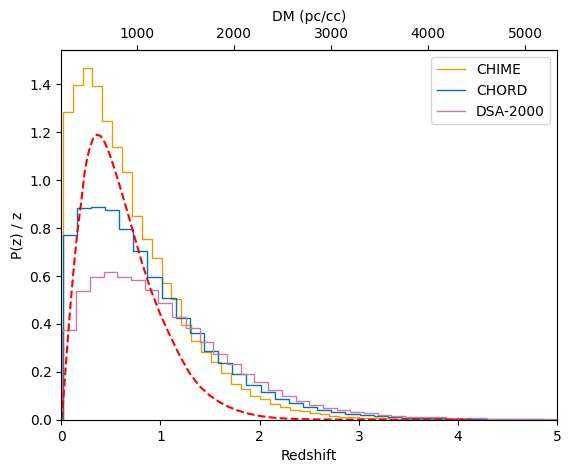

In [94]:
f, ax = plt.subplots()

# Color-blind friendly, from https://www.nature.com/articles/nmeth.1618
color = (np.array([
    (  0,   0,   0),
    (230, 159,   0),
    ( 86, 180, 233),
    (  0, 158, 115),
    (240, 228,  66),
    (  0, 114, 178),
    (213,  94,   0),
    (204, 121, 167),
]) / 255).tolist()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
y_hist = y_hist / (bins[1:] + bins[:-1]) * 2
ax.stairs(y_hist, bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist[1], bins=100, density=True)
y_hist = y_hist / (bins[1:] + bins[:-1]) * 2
ax.stairs(y_hist, bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist[1], bins=100, density=True)
y_hist = y_hist / (bins[1:] + bins[:-1]) * 2
ax.stairs(y_hist, bins, color=color[7], label='DSA-2000')

ax.set_xlabel('Redshift')
ax.set_ylabel('P(z) / z')
ax.legend()

ax.set_xlim(0, 5)



z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K
plt.plot(z_K, y / (y[:-1]*np.diff(z_K)).sum(), 'r--')


# https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1371787/full
#DM = 1021.36 * z + 221.99
#DM_igm = DM - 100
ax_t = ax.secondary_xaxis(
    'top',
    functions=(
        lambda z: 1021.36 * z + 221.99, 
        lambda DM: (DM - 221.99) / 1021.36,
    )
)
_ = ax_t.set_xlabel('DM (pc/cc)')

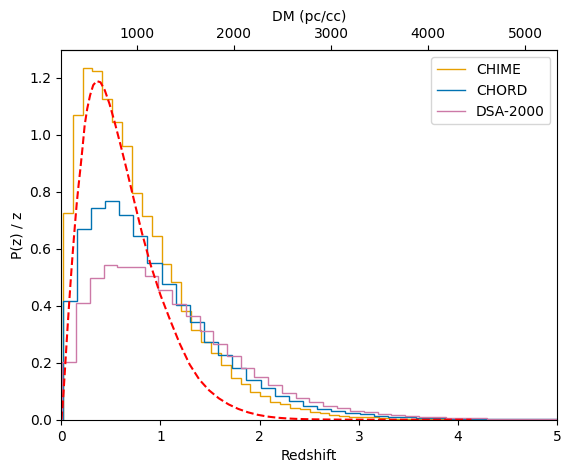

In [95]:
f, ax = plt.subplots()

# Color-blind friendly, from https://www.nature.com/articles/nmeth.1618
color = (np.array([
    (  0,   0,   0),
    (230, 159,   0),
    ( 86, 180, 233),
    (  0, 158, 115),
    (240, 228,  66),
    (  0, 114, 178),
    (213,  94,   0),
    (204, 121, 167),
]) / 255).tolist()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
y_hist = y_hist / bins[1:]
ax.stairs(y_hist, bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist[1], bins=100, density=True)
y_hist = y_hist / bins[1:]
ax.stairs(y_hist, bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist[1], bins=100, density=True)
y_hist = y_hist / bins[1:]
ax.stairs(y_hist, bins, color=color[7], label='DSA-2000')

ax.set_xlabel('Redshift')
ax.set_ylabel('P(z) / z')
ax.legend()

ax.set_xlim(0, 5)



z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K
plt.plot(z_K, y / (y[:-1]*np.diff(z_K)).sum(), 'r--')


# https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1371787/full
#DM = 1021.36 * z + 221.99
#DM_igm = DM - 100
ax_t = ax.secondary_xaxis(
    'top',
    functions=(
        lambda z: 1021.36 * z + 221.99, 
        lambda DM: (DM - 221.99) / 1021.36,
    )
)
_ = ax_t.set_xlabel('DM (pc/cc)')

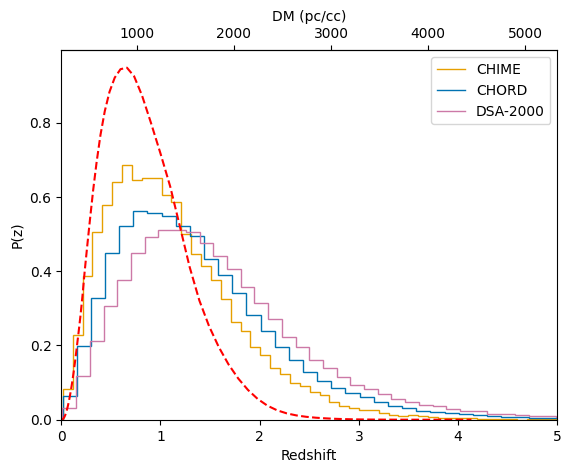

In [96]:
f, ax = plt.subplots()

# Color-blind friendly, from https://www.nature.com/articles/nmeth.1618
color = (np.array([
    (  0,   0,   0),
    (230, 159,   0),
    ( 86, 180, 233),
    (  0, 158, 115),
    (240, 228,  66),
    (  0, 114, 178),
    (213,  94,   0),
    (204, 121, 167),
]) / 255).tolist()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
ax.stairs(y_hist, bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist[1], bins=100, density=True)
ax.stairs(y_hist, bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist[1], bins=100, density=True)
ax.stairs(y_hist, bins, color=color[7], label='DSA-2000')

ax.set_xlabel('Redshift')
ax.set_ylabel('P(z)')
ax.legend()

ax.set_xlim(0, 5)



z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K * z_K
plt.plot(z_K, y / (y[:-1]*np.diff(z_K)).sum(), 'r--')


# https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1371787/full
#DM = 1021.36 * z + 221.99
#DM_igm = DM - 100
ax_t = ax.secondary_xaxis(
    'top',
    functions=(
        lambda z: 1021.36 * z + 221.99, 
        lambda DM: (DM - 221.99) / 1021.36,
    )
)
_ = ax_t.set_xlabel('DM (pc/cc)')

In [ ]:
chime_z_dist[0] * chime_z_dist[1][chime_z_dist[1]>4].size / chime_z_dist[1].size

In [ ]:
chord_z_dist[0] * chord_z_dist[1][chord_z_dist[1]>4].size / chord_z_dist[1].size

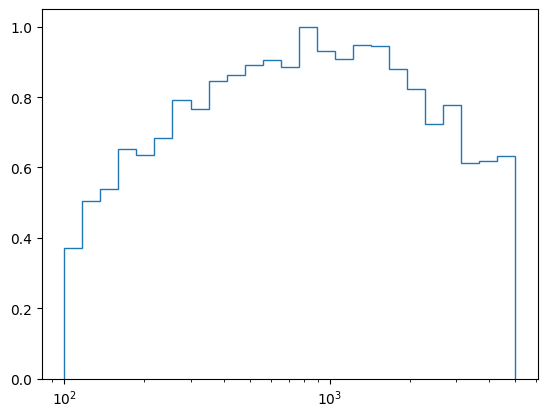

In [126]:
# CHIME selection effects on DM
# https://arxiv.org/abs/2106.04352

cdistrs = np.load('/arc/home/michilli/slf/data/corrected_distrs.npz')
curve = cdistrs[f'dm_n_wdi'] / cdistrs[f'dm_n_wi']
curve /= curve.max()
log_data_bins = cdistrs[f'dm_log_data_bins']

plt.stairs(curve, log_data_bins)
plt.xscale('log')

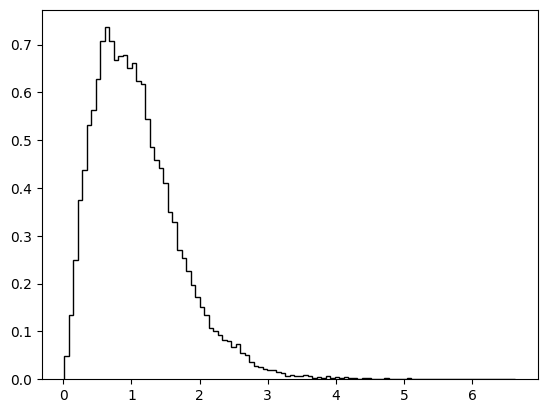

In [98]:
chime_dm = 1021.36 * chime_z_dist[1] + 221.99
log_data_pts = (log_data_bins[1:] + log_data_bins[:-1]) / 2
chime_corrections = np.interp(chime_dm, log_data_pts, curve)
random = np.random.uniform(size=chime_corrections.size)
chime_dist_corrected = chime_z_dist[1][random < chime_corrections]
y_hist, bins = np.histogram(chime_dist_corrected, bins=100, density=True)
plt.stairs(y_hist, bins, color='k', label='CHIME')

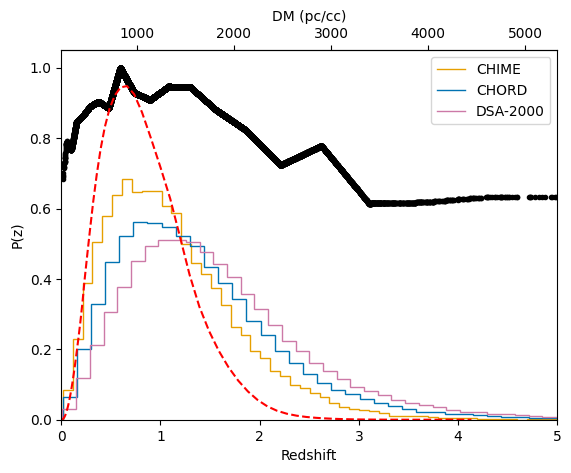

In [154]:
f, ax = plt.subplots()

# Color-blind friendly, from https://www.nature.com/articles/nmeth.1618
color = (np.array([
    (  0,   0,   0),
    (230, 159,   0),
    ( 86, 180, 233),
    (  0, 158, 115),
    (240, 228,  66),
    (  0, 114, 178),
    (213,  94,   0),
    (204, 121, 167),
]) / 255).tolist()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
ax.stairs(y_hist, bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist[1], bins=100, density=True)
ax.stairs(y_hist, bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist[1], bins=100, density=True)
ax.stairs(y_hist, bins, color=color[7], label='DSA-2000')

ax.set_xlabel('Redshift')
ax.set_ylabel('P(z)')
ax.legend()

ax.set_xlim(0, 5)

xxx = (chime_dm - 221.99) / 1021.36
ax.plot(xxx, np.interp(chime_dm, log_data_pts, curve), 'k.')


z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K * z_K
plt.plot(z_K, y / (y[:-1]*np.diff(z_K)).sum(), 'r--')


# https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1371787/full
#DM = 1021.36 * z + 221.99
#DM_igm = DM - 100
ax_t = ax.secondary_xaxis(
    'top',
    functions=(
        lambda z: 1021.36 * z + 221.99, 
        lambda DM: (DM - 221.99) / 1021.36,
    )
)
_ = ax_t.set_xlabel('DM (pc/cc)')

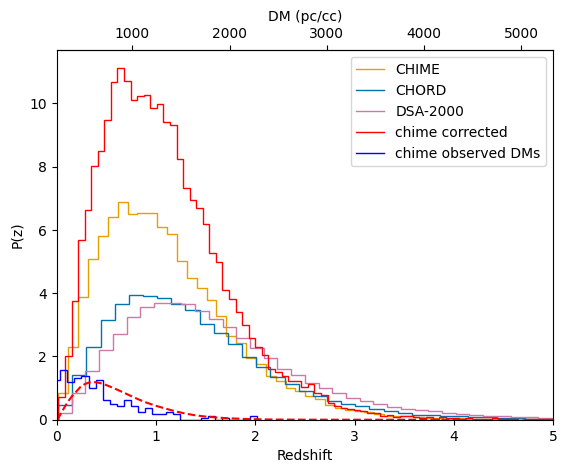

In [164]:
f, ax = plt.subplots()

# Color-blind friendly, from https://www.nature.com/articles/nmeth.1618
color = (np.array([
    (  0,   0,   0),
    (230, 159,   0),
    ( 86, 180, 233),
    (  0, 158, 115),
    (240, 228,  66),
    (  0, 114, 178),
    (213,  94,   0),
    (204, 121, 167),
]) / 255).tolist()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
y_hist = y_hist / np.diff(bins)
ax.stairs(y_hist, bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist[1], bins=100, density=True)
y_hist = y_hist / np.diff(bins)
ax.stairs(y_hist, bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist[1], bins=100, density=True)
y_hist = y_hist / np.diff(bins)
ax.stairs(y_hist, bins, color=color[7], label='DSA-2000')


y_hist, bins = np.histogram(chime_dist_corrected, bins=100, density=True)
y_hist = y_hist / np.diff(bins)
ax.stairs(y_hist, bins, color='r', label='chime corrected')

z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K #* z_K
ax.plot(z_K, y / (y[:-1]*np.diff(z_K)).sum(), 'r--')



chime_dm_obs = np.loadtxt("/arc/home/michilli/CHIMEFRB-Cat1-Energy-Dist-Distrs/data/cat1_sample.dat", skiprows=1, usecols=[2])
chime_z_obs = (chime_dm_obs - 221.99) / 1021.36
y_hist, bins = np.histogram(chime_z_obs, bins=30, density=True)
ax.stairs(y_hist, bins, color='b', label='chime observed DMs')



ax.set_xlabel('Redshift')
ax.set_ylabel('P(z)')
ax.legend()

ax.set_xlim(0, 5)


# https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1371787/full
#DM = 1021.36 * z + 221.99
#DM_igm = DM - 100
ax_t = ax.secondary_xaxis(
    'top',
    functions=(
        lambda z: 1021.36 * z + 221.99, 
        lambda DM: (DM - 221.99) / 1021.36,
    )
)
_ = ax_t.set_xlabel('DM (pc/cc)')

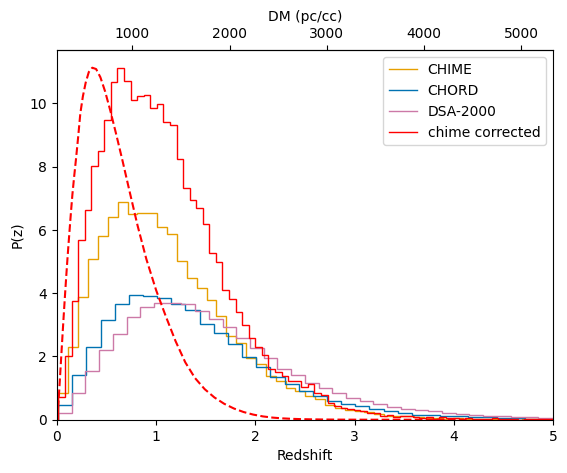

In [163]:
f, ax = plt.subplots()

# Color-blind friendly, from https://www.nature.com/articles/nmeth.1618
color = (np.array([
    (  0,   0,   0),
    (230, 159,   0),
    ( 86, 180, 233),
    (  0, 158, 115),
    (240, 228,  66),
    (  0, 114, 178),
    (213,  94,   0),
    (204, 121, 167),
]) / 255).tolist()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
y_hist = y_hist / np.diff(bins)
ax.stairs(y_hist, bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist[1], bins=100, density=True)
y_hist = y_hist / np.diff(bins)
ax.stairs(y_hist, bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist[1], bins=100, density=True)
y_hist = y_hist / np.diff(bins)
ax.stairs(y_hist, bins, color=color[7], label='DSA-2000')


y_hist, bins = np.histogram(chime_dist_corrected, bins=100, density=True)
y_hist = y_hist / np.diff(bins)
ax.stairs(y_hist, bins, color='r', label='chime corrected')


z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K
#ax.plot(z_K, y / (y[:-1]*np.diff(z_K)).sum(), 'r--')
ax.plot(z_K, y / y.max()*y_hist.max(), 'r--')


#chime_dm_obs = np.loadtxt("/arc/home/michilli/CHIMEFRB-Cat1-Energy-Dist-Distrs/data/cat1_sample.dat", skiprows=1, usecols=[2])
#chime_z_obs = (chime_dm_obs - 221.99) / 1021.36
#y_hist, bins = np.histogram(chime_z_obs, bins=30, density=True)
#y_hist = y_hist / (bins[1:] + bins[:-1]) * 2
#ax.stairs(y_hist, bins, color='b', label='chime observed DMs')


ax.set_xlabel('Redshift')
ax.set_ylabel('P(z)')
ax.legend()

ax.set_xlim(0, 5)
#ax.set_ylim(0, 2)


# https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1371787/full
#DM = 1021.36 * z + 221.99
#DM_igm = DM - 100
ax_t = ax.secondary_xaxis(
    'top',
    functions=(
        lambda z: 1021.36 * z + 221.99, 
        lambda DM: (DM - 221.99) / 1021.36,
    )
)
_ = ax_t.set_xlabel('DM (pc/cc)')

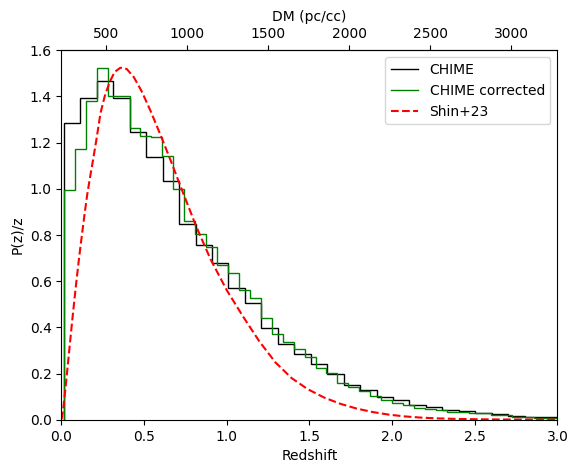

In [118]:
f, ax = plt.subplots()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
y_hist = y_hist / (bins[1:] + bins[:-1]) * 2
ax.stairs(y_hist, bins, color='k', label='CHIME')


y_hist, bins = np.histogram(chime_dist_corrected, bins=100, density=True)
y_hist = y_hist / (bins[1:] + bins[:-1]) * 2
ax.stairs(y_hist, bins, color='g', label='CHIME corrected')


z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K
ax.plot(z_K, y / y.max()*y_hist.max(), 'r--', label='Shin+23')

ax.set_xlabel('Redshift')
ax.set_ylabel('P(z)/z')
ax.legend()

ax.set_xlim(0, 3)
#ax.set_ylim(0, 2)


# https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1371787/full
ax_t = ax.secondary_xaxis(
    'top',
    functions=(
        lambda z: 1021.36 * z + 221.99, 
        lambda DM: (DM - 221.99) / 1021.36,
    )
)
_ = ax_t.set_xlabel('DM (pc/cc)')

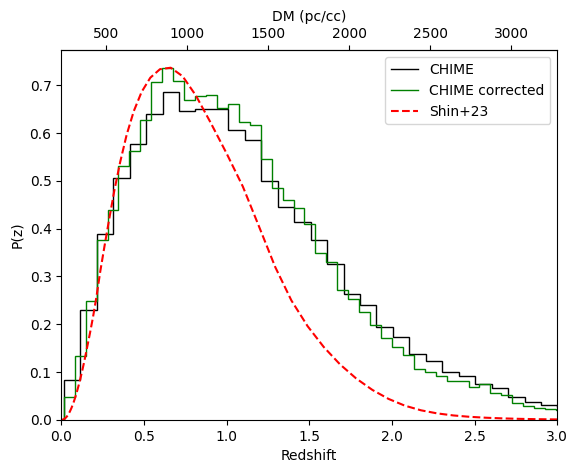

In [157]:
f, ax = plt.subplots()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
ax.stairs(y_hist, bins, color='k', label='CHIME')


y_hist, bins = np.histogram(chime_dist_corrected, bins=100, density=True)
ax.stairs(y_hist, bins, color='g', label='CHIME corrected')


z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K * z_K
ax.plot(z_K, y / y.max()*y_hist.max(), 'r--', label='Shin+23')

ax.set_xlabel('Redshift')
ax.set_ylabel('P(z)')
ax.legend()

ax.set_xlim(0, 3)
#ax.set_ylim(0, 2)


# https://www.frontiersin.org/journals/astronomy-and-space-sciences/articles/10.3389/fspas.2024.1371787/full
ax_t = ax.secondary_xaxis(
    'top',
    functions=(
        lambda z: 1021.36 * z + 221.99, 
        lambda DM: (DM - 221.99) / 1021.36,
    )
)
_ = ax_t.set_xlabel('DM (pc/cc)')

(0.0, 3.0)

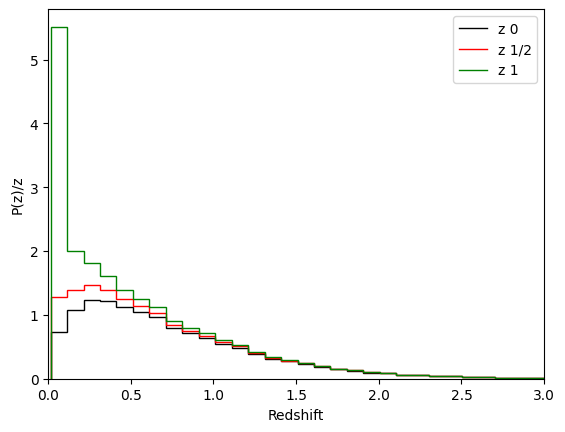

In [153]:
f, ax = plt.subplots()

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
y_hist = y_hist / bins[1:]
ax.stairs(y_hist, bins, color='k', label='z 0')

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
y_hist = y_hist / (bins[1:] + bins[:-1]) * 2
ax.stairs(y_hist, bins, color='r', label='z 1/2')

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
y_hist = y_hist / bins[:-1]
ax.stairs(y_hist, bins, color='g', label='z 1')


ax.set_xlabel('Redshift')
ax.set_ylabel('P(z)/z')
ax.legend()

ax.set_xlim(0, 3)

In [89]:
z_K[y.argmax()]

0.6620572143707693

In [81]:
bins[y_hist.argmax()]

221.249487483

In [92]:
(900 - 221.99) / 1021.36

0.6638305788360617

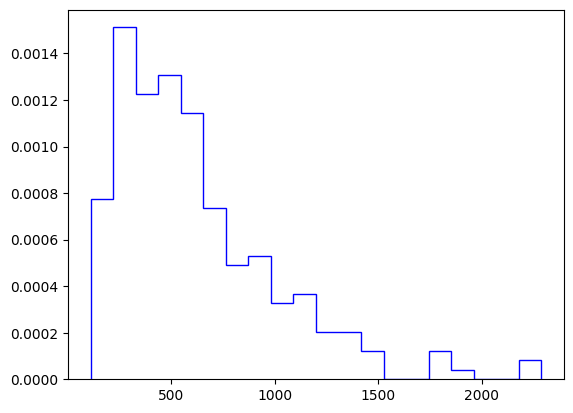

In [79]:
y_hist, bins = np.histogram(chime_dm_obs, bins=20, density=True)
plt.stairs(y_hist, bins, color='b', label='chime observed DMs')

In [68]:
chime_snr_obs = np.loadtxt("/arc/home/michilli/CHIMEFRB-Cat1-Energy-Dist-Distrs/data/cat1_sample.dat", skiprows=1, usecols=[1])

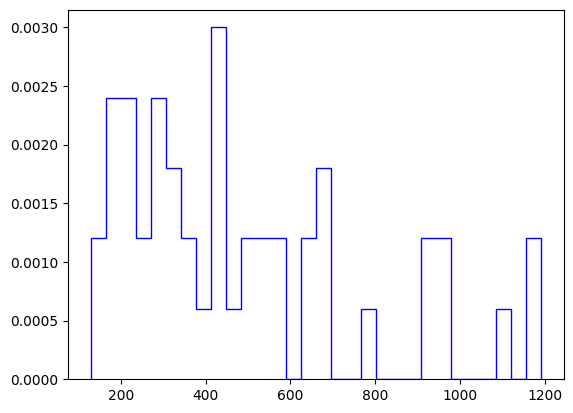

In [75]:
y_hist, bins = np.histogram(chime_dm_obs[(chime_snr_obs>=30.7)&(chime_snr_obs<=78.3)], bins=30, density=True)
plt.stairs(y_hist, bins, color='b', label='chime observed DMs')

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import erfc

y = p_K * z_K

def exponorm(x: np.ndarray, lam: float, mu: float, sigma: float) -> np.ndarray:
    return (
        lam / 2 * np.exp(lam / 2 * (2 * mu + lam * sigma**2 - 2 * x)) *
        erfc((mu + lam * sigma**2 - x) / (2**0.5 * sigma)) * x
    )

popt, pcov = curve_fit(exponorm, z_K, y)#, p0=[1, y.max(), z_K[y.argmax()]])


pdf_fitted = exponorm(z_K, *popt)

plt.plot(z_K, pdf_fitted, 'k-')
plt.plot(z_K, y, 'r--')

plt.ylim(0,1.5)

In [ ]:
y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
#y_hist = y_hist / bins[1:]
plt.stairs(y_hist, bins, color='k', label='CHIME')

y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
#y_hist = y_hist / bins[1:]
yyy = exponorm(bins[1:], *popt)
yyy /= yyy.max()
plt.stairs(y_hist * yyy, bins, color='r', label='CHIME')

plt.plot(z_K, p_K * z_K, 'g--')

In [ ]:
y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
#y_hist = y_hist / bins[1:]
plt.stairs(y_hist, bins, color='k', label='CHIME')


prob = np.random.uniform(low=0, high=1, size=chime_z_dist[1].size)
yyy = exponorm(chime_z_dist[1], *popt)
yyy /= yyy.max()
aaa = chime_z_dist[1][yyy>prob].copy()

y_hist, bins = np.histogram(aaa, bins=100, density=True)
plt.stairs(y_hist, bins, color='r', label='CHIME')

plt.plot(z_K, p_K * z_K * 2, 'g--')

In [ ]:
# CHIME
chime_z_dist = run_simulation(
    int(1e6),
    telescope_name = 'chime',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# dummy
dummy_z_dist = run_simulation(
    int(1e6),
    telescope_name = 'dummy',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

In [ ]:
y_hist, bins = np.histogram(chime_z_dist[1], bins=100, density=True)
y_hist = y_hist / bins[1:]
plt.stairs(y_hist/y_hist.max(), bins, color='k', label='CHIME')

y_hist, bins = np.histogram(dummy_z_dist[1], bins=100, density=True)
y_hist = y_hist / bins[1:]
plt.stairs(y_hist/y_hist.max(), bins, color='g', label='dummy')

plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.legend()

plt.xlim(0, 3)

z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K #* z_K
plt.plot(z_K, y / y.max(), 'r--')

In [ ]:
chime_z_dist[0]

# test

In [ ]:
dummy_z_dist = run_simulation(
    int(1e6),
    telescope_name = 'dummy',
    simulate_lensed_frbs = False,
    return_z_dist = True
)
print(dummy_z_dist[0])
bins = np.linspace(0, 10, 100)

In [ ]:
y_hist, bins = np.histogram(dummy_z_dist[1], bins=bins, density=True)
plt.stairs(y_hist, bins, color='k', label='test')

y_hist, bins = np.histogram(chime_z_dist[1], bins=bins, density=True)
plt.stairs(y_hist, bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist[1], bins=bins, density=True)
plt.stairs(y_hist, bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist[1], bins=bins, density=True)
plt.stairs(y_hist, bins, color=color[7], label='DSA-2000')

plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.legend()

plt.xlim(0, 3)


z_K, p_K = np.loadtxt('data/P_obs(z).dat', skiprows=4).T
y = p_K * z_K
y_int = np.interp(bins, z_K, y)
plt.step(bins, y_int / y_int.sum() / (bins[1] - bins[0]), color='r')

In [ ]:
telescope = Telescope(name='chime')
telescope.sefd()

In [ ]:
telescope = Telescope(name='dummy')
telescope.sefd()

In [ ]:
telescope = Telescope(name='dsa2000')
telescope.sefd()

# FRB Euclid discovery rate

## Parameters of the simulations

In [ ]:
# External data
# Redshift and magnitude distributions of lensed galaxies detected by Euclid
# From https://ui.adsabs.harvard.edu/abs/2015ApJ...811...20C/abstract
data_lensed_galaxies = 'data/lenses_Euclid.txt'
# Unlensed galaxy population used in Collett 2015
data_unlensed_catalog = 'data/lsst_source_catalog.txt'
# Position, magnification, and time delay of images for a point source
data_sie_catalog = 'data/SIE.csv'
# Simulations of scattering from the lens
data_lens_scattering = 'data/lens_scattering.csv'
# Emcee sampler output for Shin+23 uncertainties
data_frb_model_sampler = 'data/frb_model_sampler.p'

## Function definitions

In [ ]:
def get_lensed_galaxy_fraction(
    zmin = None,
    zmax = None,
    frbs_evolve_with_luminosity = True,
):
    """ Fraction of lensed galaxies as a function of redshift from Collett 2015.
    """
    # Unlensed (org) and lensed (sim) galaxy populations used in Collett 2018 simulations
    # Redshift distributions
    z_org = np.loadtxt(data_unlensed_catalog, usecols=2, delimiter=',')
    z_sim = np.loadtxt(data_lensed_galaxies, usecols=1, skiprows=1)
    
    # Ensures that there are ~100 galaxies per step on average
    if zmin is None:
        zmin = max(z_org.min(), z_sim.min())
    if zmax is None:
        zmax = min(z_org.max(), z_sim.max())
    z = np.linspace(zmin, zmax, z_org.size//100+1)
    z_mean = (z[1:] + z[:-1]) / 2
    
    # Lensed and total galaxies per redshift bin
    Pz_sim, _ = np.histogram(z_sim, bins=z)
    Pz_org, _ = np.histogram(z_org, bins=z)
    
    # Select bins containing enough galaxies
    idx = (Pz_sim > 10) & (Pz_org > 10)
    Pz_sim = Pz_sim[idx]
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt(data_unlensed_catalog, usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        PL_org = PL_org[idx]
        # Luminosity of lensed galaxies used from Collett 2018 simulations
        Mv_sim = np.loadtxt(data_lensed_galaxies, usecols=15, skiprows=1) * u.M_bol # Magnitude distribution
        L_sim = Mv_sim.to(u.L_sun)
        # Total luminosity of lensed galaxy population per redshift step
        PL_sim, _ = np.histogram(
            z_sim, 
            bins=z, 
            weights=L_sim
        )
        PL_sim = PL_sim[idx]
        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = PL_sim / PL_org

    else:
        Pz_org = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Fraction of lensed galaxies per redshift step
        lensed_fraction = Pz_sim / Pz_org
        
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    #lensed_fraction_iterp = spline(z_mean, lensed_fraction, extrapolate=False)
    lensed_fraction_iterp = np.poly1d(np.polyfit(z_mean, lensed_fraction, 2))
    return lensed_fraction_iterp


def get_unlensed_galaxy_distribution(
    zmin,
    zmax,
    frbs_evolve_with_luminosity = True,
):
    """ Distribution of unlensed galaxies as a function of redshift from Collett 2015.
    """
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt(data_unlensed_catalog, usecols=2, delimiter=',')
    
    # Ensures that there are ~100 galaxies per step on average
    z = np.linspace(zmin, zmax, z_org.size//100+1)
    z_mean = (z[1:] + z[:-1]) / 2
    
    # Total galaxies per redshift bin
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = Pz_org > 10
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt(data_unlensed_catalog, usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        probability_norm = PL_org[idx]
    else:
        probability_norm = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        
    # Smooth the output
    unlensed_galaxy_dist = gf(probability_norm, 6)
    # Interpolate with a spline
    unlensed_galaxy_interp = spline(z_mean, unlensed_galaxy_dist, extrapolate=False)
    
    # Size of unlensed galaxy population
    z_min = z_mean.min()
    z_max = z_mean.max()
    return unlensed_galaxy_interp, z_min, z_max


def get_distribution_dist_lensed(
    number_of_simulated_frbs,
    alpha_spect,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = True,
):
    """Distribution of the distance factor for lensed FRBs.
    """
    # Redshift distribution of unlensed galaxies used in Collett 2015
    # Catalog of lensed galaxies
    lensed_galaxies = pd.read_csv(
        data_lensed_galaxies,
        delim_whitespace=True
    )
    if z_max is None:
        z_max = lensed_galaxies['z_s'].max()
    if z_min is None:
        z_min = lensed_galaxies['z_s'].min()
    (unlensed_galaxy_interp,
        z_min,
        z_max
    )= get_unlensed_galaxy_distribution(
        z_min,
        z_max,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
    )
    lensed_galaxies = lensed_galaxies[
        (lensed_galaxies['z_s'] >= z_min) &
        (lensed_galaxies['z_s'] <= z_max)
    ]
            
    # Redshift distribution of FRBs in the Universe
    y_max, z_pdf_norm, frb_emission_rate = set_distribution_redshift(
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )

    # Redshift distribution of lensed FRB hosts
    if frbs_evolve_with_luminosity:
        # Luminosity fraction of each galaxy in its redshift bin
        lensed_galaxies_Mv = lensed_galaxies['M_absolute_source_r'].to_numpy() * u.M_bol
        p = (
            z_pdf_norm(lensed_galaxies['z_s'].to_numpy()) / 
            unlensed_galaxy_interp(lensed_galaxies['z_s']) * 
            lensed_galaxies_Mv.to(u.L_sun)
        )
    else:
        # Fraction of each galaxy in its redshift bin 
        p = (
            z_pdf_norm(lensed_galaxies['z_s']) / 
            unlensed_galaxy_interp(lensed_galaxies['z_s'])
        )

    # Table of host galaxies
    galaxy_index = rng.choice(
        np.arange(lensed_galaxies['z_s'].size, dtype=int),
        p = p / p.sum(),
        size = number_of_simulated_frbs
    )
    hosts = lensed_galaxies.iloc[galaxy_index]
    hosts.reset_index(drop=True, inplace=True)

    # Redshift distribution of FRB hosts
    z_dist = hosts['z_s'].to_numpy()

    # Distance factor
    Dl = get_Dl(z_dist)
    dist_factor = (4 * np.pi * Dl**2) / (1 + z_dist)**(2+alpha_spect)
    return dist_factor, z_dist.min(), z_dist.max(), frb_emission_rate, hosts, z_dist


def get_magnified_images(
    hosts,
    sie_org = None
):
    """Magnification factors based on simulations of point sources in lensed galaxies."""
    # Load simulation results
    if sie_org is None:
        sie_org = pd.read_csv(data_sie_catalog, index_col=['q', 0])
        sie_org.index.names = ['q','id']
        sie_org.sort_index(inplace=True)
    sie = sie_org.loc[np.sort(hosts['q_l'].clip(0.01, 0.99).unique())]
    sie.sort_index(inplace=True)
    
    # FRB distribution within the hosts
    frb_host_dist = (
        rng.exponential(size=hosts.shape[0]) *
        hosts['halflightradius_s(arcsec)'].to_numpy() *
        u.arcsec
    )
    frb_host_angle = rng.uniform(low=0, high=2*np.pi, size=hosts.shape[0]) * u.rad
    # FRB coordinates in the lens refenrence in units of Einstein radius
    frb_host_x = frb_host_dist * np.cos(frb_host_angle)
    frb_host_y = frb_host_dist * np.sin(frb_host_angle)
    frb_lens_x = frb_host_x + hosts['x_s_unlensed'].to_numpy() * u.arcsec
    frb_lens_y = frb_host_y + hosts['y_s_unlensed'].to_numpy() * u.arcsec
    frb_lens_x_Er = frb_lens_x / hosts['R_Ein(arcsec)'].to_numpy() / u.arcsec
    frb_lens_y_Er = frb_lens_y / hosts['R_Ein(arcsec)'].to_numpy() / u.arcsec
    frb_lens_dist_Er = np.hypot(frb_lens_x_Er, frb_lens_y_Er).value
    
    # Create a KD tree to find nearest point
    tree = KDTree(list(map(list, zip(*[
        sie.index.get_level_values(0).to_numpy(),
        np.hypot(sie['RA'], sie['DEC']).to_numpy()
    ]))))
    
    # Query KD tree for each host
    _, sie_idx = tree.query(list(map(list, zip(*[
        hosts['q_l'].to_numpy(),
        frb_lens_dist_Er
    ]))))
    
    return sie.iloc[sie_idx].sort_index()


def get_scattering_lens(
    hosts,
    sie
):
    # Impact parameter in the lens frame for each image for Reinstein=1
    impact_parameters = pd.DataFrame()
    for n in range(1, 5):
        impact_parameters[f'im{n}'] = (
            np.sqrt(
                np.sum(
                    sie[[f'im{n}_RA', f'im{n}_DEC']]**2,
                    axis=1
                )
            )  
        )
    # Rescale to Reinstein and Re
    impact_parameters = impact_parameters.multiply(
        (
            hosts['R_Ein(arcsec)'] /
            hosts['halflightradius_s(arcsec)']
        ).to_numpy(),
        axis=0
    )
    
    # Calculate lens galaxy masses from dispersion velocity
    # From https://arxiv.org/pdf/1208.3522.pdf, Eq. 21
    lens_mass = (
        2.5 * 
        (hosts['sigma(km/s)'].to_numpy() *u.km / u.s)**2 *
        (hosts['halflightradius_l(arcsec)'].to_numpy() *u.arcsec).to(u.rad).value *
        cosmo.angular_diameter_distance(hosts['z_l'].to_numpy()) / 
        const.G
    ).to(u.M_sun)
    
    # Calculate scattering at the impact parameters
    # Load scattering values
    lens_scattering = pd.read_csv(data_lens_scattering)
    # Create interpolator
    scattering_interp = RegularGridInterpolator(
        [
            lens_scattering['impact_param'],
            [1e9, 1e10, 1e11, 1e12],
        ],
        lens_scattering[[
            'tau_9Msun',
            'tau_10Msun',
            'tau_11Msun',
            'tau_12Msun',
        ]].to_numpy(),
        bounds_error = False,
        fill_value = None
    )
    # Points to evaluate    
    frb_lens_scattering = pd.DataFrame()
    for n in range(1, 5):
        frb_lens_scattering[f'im{n}'] = ((
            scattering_interp(
                np.vstack([
                    impact_parameters[f'im{n}'].to_numpy(),
                    lens_mass.value
                ]).T
            )  * u.ms / u.pc).to(u.ms / u.Mpc).value
        )
    frb_lens_scattering.clip(0, None, inplace=True)
    
    # Multiply by a factor (dls*dlo/dso)*(1+zl)^(-3) (Ocker+23)
    dls = cosmo.angular_diameter_distance_z1z2(
        hosts['z_l'].to_numpy(),
        hosts['z_s'].to_numpy()
    ).to(u.Mpc).value
    dlo = cosmo.angular_diameter_distance(hosts['z_l'].to_numpy()).to(u.Mpc).value
    dso = cosmo.angular_diameter_distance(hosts['z_s'].to_numpy()).to(u.Mpc).value
    zl = hosts['z_l'].to_numpy()
    frb_lens_scattering = frb_lens_scattering.multiply(
        dls * dlo / dso / (1 + zl)**3,
        axis=0
    )
    return frb_lens_scattering


def get_lensed_frb_detections(
    rng,
    hosts,
    frb_snr,
    z_min,
    z_max,
    frb_E_nu,
    frb_dist_fact,
    frb_bw,
    frb_w,
    frb_tau,
    freq_mean,
    frbs_evolve_with_luminosity = True,
    sie = None
):
    # Magnification factors
    sie = get_magnified_images(
        hosts,
        sie_org = sie
    )
    hosts.reset_index(drop=True, inplace=True)
    mu = sie[["mu_1", "mu_2", "mu_3", "mu_4"]]
    mu.columns = [f"im{i}" for i in range(1,5)]

    # First pass to reduce the number of FRBs
    # S/N of the unlensed FRB detected in a follow-up observation
    snr_followup = get_snr(
        rng,
        frb_E_nu,
        frb_dist_fact,
        frb_bw,
        frb_w,
        frb_tau,
        1,
        1,
        1, 
        Telescope(name=telescope_followup).sefd(), 
        rfi_band,
    )

    # FRBs with magnified S/N > SNr_min_followup in follow-up observations
    snr_images_followup = mu.multiply(snr_followup, axis=0)
    idx_images_followup = ((snr_images_followup > SNr_min_followup).sum(axis=1) > 1).to_numpy()
    hosts = hosts[idx_images_followup].reset_index(drop=True)
    sie = sie[idx_images_followup].reset_index(drop=True)
    mu = mu[idx_images_followup].reset_index(drop=True)
    frb_snr = frb_snr[idx_images_followup]
    frb_tau = frb_tau[idx_images_followup]

    # FRBs with magnified S/N > SNr_min in discovery observations
    snr_images = mu.multiply(frb_snr, axis=0)
    idx_snr_images = ((snr_images > SNr_min).sum(axis=1) > 1).to_numpy()
    hosts = hosts[idx_snr_images].reset_index(drop=True)
    sie = sie[idx_snr_images].reset_index(drop=True)
    mu = mu[idx_snr_images].reset_index(drop=True)
    frb_snr = frb_snr[idx_snr_images]
    frb_tau = frb_tau[idx_snr_images]

    # Scattering in the lens
    if hosts.shape[0] == 0:
        return 0, None
    tau_lens = get_scattering_lens(
        hosts,
        sie,
    ) # @ 1 GHz
    # Add to unlensed scattering
    frb_tau = (tau_lens  * (freq_mean / 1000 / u.MHz)**-4).add(frb_tau, axis=0)

    # Second pass with total scattering
    frb_E_nu = frb_E_nu[idx_images_followup][idx_snr_images]
    frb_dist_fact = frb_dist_fact[idx_images_followup][idx_snr_images]
    frb_bw = frb_bw[idx_images_followup][idx_snr_images]
    frb_w = frb_w[idx_images_followup][idx_snr_images]
    snr_followup = pd.DataFrame()
    for n in range(1, 5):
        snr_followup[f'im{n}'] = (
            get_snr(
                rng,
                frb_E_nu,
                frb_dist_fact,
                frb_bw,
                frb_w,
                frb_tau[f'im{n}'].to_numpy() * u.ms,
                1,
                1,
                1, 
                Telescope(name=telescope_followup).sefd(), 
                rfi_band,
            )
        )

    # FRBs with magnified S/N > SNr_min_followup in follow-up observations
    snr_images_followup = mu.multiply(snr_followup, axis=0)
    idx_images_followup = ((snr_images_followup > SNr_min_followup).sum(axis=1) > 1).to_numpy()
    mu = mu[idx_images_followup].reset_index(drop=True)
    hosts = hosts[idx_images_followup].reset_index(drop=True)
    frb_snr = frb_snr[idx_images_followup]
    # FRBs with magnified S/N > SNr_min in discovery observations
    snr_images = mu.multiply(frb_snr, axis=0)
    snr_images = snr_images.loc[(snr_images > SNr_min).sum(axis=1) > 0]
    
    # Weigh detections by the fraction of lensed galaxies to calculate a physical rate
    # Index of each host with multiple images counted multiple times
    idx_detected_frbs = [idx for idx,snrs in enumerate(snr_images.to_numpy()) for snr in snrs[snrs > SNr_min][:-1]]
    detected_frbs_z_dist = hosts['z_s'].to_numpy()[idx_detected_frbs]
    # Fraction of lensed galaxies per redshift bin
    lensed_fraction_interp = get_lensed_galaxy_fraction(
        zmin = z_min,
        zmax = z_max,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
    )
    # Integral of detections weighted by the lensed galaxy fraction
    detected_frbs = np.nansum(lensed_fraction_interp(detected_frbs_z_dist))
    return detected_frbs, detected_frbs_z_dist


def get_detection_rate_lensed(
    rng,
    number_of_simulated_frbs,
    frb_population,
    telescope,
    frbs_evolve_with_luminosity = True,
    uncertain=False,
    return_z_dist = False,
    sie = None,
    verbose = False
):
    """Rate of FRB detections.
    """
    # Properties of the FRB population
    frb_properties = frb_population.get_parameters(uncertain = uncertain, rng = rng)
    # Frequency channels spaced by ~30 MHz
    n_ch = int(np.clip(
        (telescope.bandwidth() // (30 * u.MHz)).to(u.dimensionless_unscaled),
        1, np.inf
    ).value)
    freq_channels = np.linspace(telescope.v0(), telescope.v1(), n_ch)

    # FRB widths
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 0.97
    scale = 1.0 * u.ms
    frb_w = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    
    # FRB scattering
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 1.72
    scale = 2.02 * u.ms
    frb_tau = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    # frb_tau = np.ones(number_of_simulated_frbs) * 50 * u.ms
    # Rescale to central frequency
    freq_mean = (telescope.v0() + telescope.v1()) / 2
    frb_tau = frb_tau * (freq_mean / 600 / u.MHz)**-4
    
    # FRB time correction
    frb_w_correction = np.sqrt(frb_w / w_telescope).clip(max=1)
    
    # Beam response
    sky_fraction, beam_response = get_beam_response(
        number_of_simulated_frbs,
        telescope,
        freq_channels,
    )
    
    # FRB redshifts
    (
        frb_dist_fact,
        z_min,
        z_max,
        frb_emission_rate,
        hosts,
        frb_dist_z
    ) = get_distribution_dist_lensed(
        number_of_simulated_frbs,
        frb_properties['alpha_spect'],
        frb_properties['alpha_rate'],
        frb_properties['frb_emission_rate_z0_Epivot'],
        frb_properties['n_sfr'],
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
    )
    
    # FRB energies
    # Minimum energy that can be detected from current sample
    Emin = (
        u.GHz * SNr_min / beam_response.max(axis=0) *
        telescope.sefd(freq=telescope.v1()) *  # SEFD at the top of the band
        np.sqrt((frb_w + frb_tau) / telescope.bandwidth() / 2) / 
        frb_w_correction / np.sqrt(1 - rfi_band) * frb_dist_fact
    ).min().to(u.erg)
    # Energy distribution
    frb_E = get_distribution_E(
        number_of_simulated_frbs,
        Emin,
        frb_properties['Echar'],
        frb_properties['gamma'],
    )
    # Energy spectral density distribution
    frb_E_nu = frb_E / u.GHz
    
    # FRB S/N values
    frb_snr = get_snr(
        rng,
        freq_channels,
        frb_E_nu,
        frb_dist_fact,
        frb_w, 
        frb_tau,
        frb_w_correction,
        frb_properties['alpha_spect'],
        telescope,
        beam_response, 
        uncertain = uncertain
    )
    
    detected_frbs_sim, frb_dist_z = get_lensed_frb_detections(
        hosts,
        frb_snr,
        z_min,
        z_max,
        frb_E_nu,
        frb_dist_fact,
        frb_bw,
        frb_w,
        frb_tau,
        freq_mean,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
        sie = sie
    )
    if verbose:
        print(f"A total of {detected_frbs_sim} FRBs are detected.")
    
    # Convert to a physical detection rate
    frb_detection_rate = convert_to_rate(
        number_of_simulated_frbs,
        detected_frbs_sim,
        Emin,
        frb_emission_rate,
        sky_fraction,
        frb_properties['Echar'],
        frb_properties['gamma'],
        frb_properties['Epivot'],
    )
    detection_rate_real = frb_detection_rate * observing_time_fraction
    if return_z_dist:
        # The redshift distribution is needed
        return detection_rate_real, list(frb_dist_z[frb_snr > SNr_min])
    else:
        return detection_rate_real
    

## Figures

### Fig XX

# Other

In [ ]:
n_frbs = 536
obs_time = 214.8 * 24 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
rate, err

In [ ]:
_ = run_simulation(
    int(1e6),
    telescope_name = 'chord',
    verbose=True
)

In [ ]:
detection_rate, frb_dist_z = run_simulation(
    int(1e6),
    telescope_name = 'chord',
    verbose=True,
    return_z_dist=True
)

In [ ]:
%%timeit 
_ = run_simulation(
    int(5e6),
    telescope_name = 'chord'
)

In [ ]:
# Timing of simulation
n = [1e4, 1e5, 1e6, 5e6, 1e7]
t = [0.338, 0.792, 5.94, 29.6, 63]  # s

m, q = np.polyfit(n, t, 1)

plt.plot(n, t, 'ko')
plt.plot(n, np.poly1d([m, q])(n), 'r--')

In [ ]:
1e8 * m + q

In [ ]:
# argos + GBT
print('argos + GBT')
telescope_name = 'argos'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

# argos + DSA-2000
print('argos + DSA-2000')
telescope_name = 'argos'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# argos + argos
print('argos + argos')
telescope_name = 'argos'
telescope_followup = 'argos'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

In [ ]:
frbs_narrowband = False

# argos + GBT
print('argos + GBT')
telescope_name = 'argos'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

# argos + DSA-2000
print('argos + DSA-2000')
telescope_name = 'argos'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# argos + argos
print('argos + argos')
telescope_name = 'argos'
telescope_followup = 'argos'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

In [ ]:
# sl-FRBs detection rates

In [ ]:
# CHORD + GBT
print('CHORD + GBT')
telescope_name = 'chord'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# CHORD + DSA-2000
print('CHORD + DSA-2000')
telescope_name = 'chord'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# DSA-2000 + GBT
print('DSA-2000 + GBT')
telescope_name = 'dsa2000'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# DSA-2000 + DSA-2000
print('DSA-2000 + DSA-2000')
telescope_name = 'dsa2000'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

In [ ]:
frbs_narrowband = False

# CHORD + GBT
print('CHORD + GBT')
telescope_name = 'chord'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# CHORD + DSA-2000
print('CHORD + DSA-2000')
telescope_name = 'chord'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# DSA-2000 + GBT
print('DSA-2000 + GBT')
telescope_name = 'dsa2000'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# DSA-2000 + DSA-2000
print('DSA-2000 + DSA-2000')
telescope_name = 'dsa2000'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

In [ ]:
# Total number of FRBs
print(0.2206 / 3 * 2 + 0.2508 / 3+ 0.3537 / 3 * 2 + 0.4748 / 3 )
print(0.0683 / 3 * 2 + 0.0938 / 3+ 0.1565 / 3 * 2 + 0.2028 / 3 )
print(1.4436 / 3 * 2 + 1.3732 / 3+ 2.2291 / 3 * 2 + 3.4431 / 3 )

In [ ]:
0.2508 / 3 + 0.2206 / 3 * 2 + 0.4748 / 3 + 0.3537 / 3 * 2

In [ ]:
# CHORD + GBT
print('CHORD + GBT')
telescope_name = 'chord'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# CHORD + DSA-2000
print('CHORD + DSA-2000')
telescope_name = 'chord'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# CHORD + CHORD
print('CHORD + CHORD')
telescope_name = 'chord'
telescope_followup = 'chord'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

In [ ]:
# CHORD + GBT
print('CHORD + GBT')
telescope_name = 'chord'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)

print(f'{frb_detection_rate.value:.2f} # {frb_detection_rate_low.value:.2f} / {frb_detection_rate_high.value:.2f}')
print(f'{frb_detection_rate.value:.2f} - {(frb_detection_rate - frb_detection_rate_low).value:.2f} + {(frb_detection_rate_high - frb_detection_rate).value:.2f}')
print(f'{uncert_med.value:.2f}')
print()

# CHORD + DSA-2000
telescope_name = 'chord'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)

print(f'{frb_detection_rate.value:.2f} # {frb_detection_rate_low.value:.2f} / {frb_detection_rate_high.value:.2f}')
print(f'{frb_detection_rate.value:.2f} - {(frb_detection_rate - frb_detection_rate_low).value:.2f} + {(frb_detection_rate_high - frb_detection_rate).value:.2f}')
print(uncert_med)

# DSA-2000 + GBT
telescope_name = 'dsa2000'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)

print(f'{frb_detection_rate.value:.2f} # {frb_detection_rate_low.value:.2f} / {frb_detection_rate_high.value:.2f}')
print(f'{frb_detection_rate.value:.2f} - {(frb_detection_rate - frb_detection_rate_low).value:.2f} + {(frb_detection_rate_high - frb_detection_rate).value:.2f}')
print(uncert_med)

# DSA-2000 + DSA-2000
telescope_name = 'dsa2000'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)

print(f'{frb_detection_rate.value:.2f} # {frb_detection_rate_low.value:.2f} / {frb_detection_rate_high.value:.2f}')
print(f'{frb_detection_rate.value:.2f} - {(frb_detection_rate - frb_detection_rate_low).value:.2f} + {(frb_detection_rate_high - frb_detection_rate).value:.2f}')
print(uncert_med)

In [ ]:
# Redshift distribution of detected FRBs

# CHIME
chime_z_dist = run_simulation(
    int(1e6),
    telescope_name = 'chime',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# ASKAP
askap_z_dist = run_simulation(
    int(1e7),
    telescope_name = 'askap',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# CHORD
chord_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'chord',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# DSA-2000
dsa_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'dsa2000',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

In [ ]:
# Color-blind friendly, from https://www.nature.com/articles/nmeth.1618
color = (np.array([
    (  0,   0,   0),
    (230, 159,   0),
    ( 86, 180, 233),
    (  0, 158, 115),
    (240, 228,  66),
    (  0, 114, 178),
    (213,  94,   0),
    (204, 121, 167),
]) / 255).tolist()

y_hist, bins = np.histogram(chime_z_dist, bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist, bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist, bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[7], label='DSA-2000')

y_hist, bins = np.histogram(askap_z_dist, bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[3], label='ASKAP')

ASKAP_FRBs = [0.23, 0.161, 0.36879, 0.12927, 0.2797, 0.3214, 0.4755, 0.291, 0.1178, 0.378, 0.522, 0.209, 0.243, 0.2145, 0.0469, 0.0715]
# from https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.4862J/abstract
y_hist, bins = np.histogram(ASKAP_FRBs, bins=7, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color='k', label='ASKAP detection') #, ls='--'

plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.legend()

plt.xlim(0, 5)

In [ ]:
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
observing_time_fraction = 1  # Fraction of observing time
number_of_simulated_frbs = int(1e6)
SNr_min = 12

t = 'chime'
telescope = t.lower()
# Shin model
value = run_simulation(
        number_of_simulated_frbs,
        telescope_name = telescope,
        simulate_lensed_frbs = False,
        model = 'shin',
        uncertain = False,
        verbose = False,
    ).to(1/u.yr).value
uncert = np.array([
    run_simulation(
        number_of_simulated_frbs // 100,
        telescope_name = telescope,
        simulate_lensed_frbs = False,
        model = 'shin',
        uncertain = True,
        verbose = False
    ).to(1/u.yr).value for n in range(100)
])
uncert_down = np.percentile(uncert[uncert>0], 16)
uncert_up = np.percentile(uncert[uncert>0], 84)
med = np.median(uncert[uncert>0])

In [ ]:
value, uncert_down, uncert_up, med

In [ ]:
# Redshift distribution

In [ ]:
frb_properties = FRB_Population(name='shin').get_parameters()

(
    frb_dist_fact,
    z_min,
    z_max,
    frb_emission_rate,
    hosts,
    frb_dist_z_lens
) = get_distribution_dist(
    int(1e5),
    frb_properties['alpha_spect'],
    frb_properties['alpha_rate'],
    frb_properties['frb_emission_rate_z0_Epivot'],
    frb_properties['n_sfr'],
    simulate_lensed_frbs = True,
    frbs_evolve_with_luminosity = True,
)

(
    frb_dist_fact,
    z_min,
    z_max,
    frb_emission_rate,
    hosts,
    frb_dist_z_unlens
) = get_distribution_dist(
    int(1e5),
    frb_properties['alpha_spect'],
    frb_properties['alpha_rate'],
    frb_properties['frb_emission_rate_z0_Epivot'],
    frb_properties['n_sfr'],
    simulate_lensed_frbs = False,
    frbs_evolve_with_luminosity = True,
    z_min = z_min,
    z_max = z_max
)

In [ ]:
lensed_fraction = gf(lensed_fraction, 6)

In [ ]:
y_hist, bins = np.histogram(frb_dist_z_lens, bins=100, density=True)
plt.stairs(gf(y_hist, 6), bins, color='k', label='Lensed')

y_hist, bins = np.histogram(frb_dist_z_unlens, bins=100, density=True)
plt.stairs(y_hist, bins, color='r', label='Unlensed')

plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.legend()

plt.xlim(0, z_max)

In [ ]:
# Fraction of sky observed by CHORD at maximum elevation

In [ ]:
a=EarthLocation.of_site('DRAO')

In [ ]:
dec = a.lat + 30 * u.deg

In [ ]:
360 / (np.sqrt(130/np.pi)*2 / np.cos(np.deg2rad(dec)))

In [ ]:
360 / (np.sqrt(5/np.pi)*2 / np.cos(np.deg2rad(dec)))

In [ ]:
30000 / 10.6

In [ ]:
# Follow-up
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

In [ ]:
source_low_dec = SkyCoord(ra=0*u.deg, dec=-10*u.deg)
source_mid_dec = SkyCoord(ra=0*u.deg, dec=45*u.deg)
source_high_dec = SkyCoord(ra=0*u.deg, dec=89*u.deg)

In [ ]:
gbt = EarthLocation.of_site('GBT')
gmrt = EarthLocation.of_site('GMRT')
eff = EarthLocation.of_site('Effelsberg')

In [ ]:
# Low dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_low_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_low_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_low_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = -10 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

In [ ]:
# Mid dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_mid_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_mid_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_mid_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 45 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

In [ ]:
# High dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_high_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_high_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_high_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 89 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

In [ ]:
# FRB radial distribution within host galaxies

#https://arxiv.org/pdf/2009.10747.pdf
#https://arxiv.org/pdf/2302.14782.pdf
#https://arxiv.org/pdf/2108.01282.pdf
#https://arxiv.org/pdf/2301.01000.pdf

# i-band and r-band
offset = np.array([0.6, 5.5, 3.4, 1.2, 2.0, 27, 6.6, 11, 3.2, 1.9, 11, 3.0, 9.87, 3.80, 10.8, 5.7, 5.9, 2.3])
reff = np.array([0.7, 3.6, 2.7, 7.2, 4.4, 3.3, 2.8, 2.1, 2.9, 3.9, 5.5, 1.6, 2.67, 6.64, 5.80, 1.78, 7.58, 2.7])

r = np.sort(offset / reff)
F = np.arange(r.size)/r.size

from scipy import stats
y_hist, bins = np.histogram(r, bins=np.arange(10), density=False)
plt.stairs(y_hist, bins, color='k')

x = np.linspace(0, x_hist.max(), 100)
y = np.exp(-x/2)
plt.plot(x+0.5, y*y_hist.max(), 'k--', label='exp(dR)')
plt.xlabel('Reff')
plt.ylabel('FRBs')

In [ ]:
# Host luminosity distribution
mag = np.array([-16.20, -19.46, -20.81, -20.40, -19.85, -22.06, -21.22, -19.01, -19.92, -22.13, -18.05, -18.80, -21.38, -20.18, -18.26, -21.49]) * u.M_bol
y_hist, bins = np.histogram(mag.to(u.L_sun).value, bins=10, density=True)
plt.stairs(y_hist, bins, color='k')

M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
M_org = M_org[z_org<1]
y_hist_org, bins = np.histogram(M_org.to(u.L_sun).value, bins=bins, density=True)
plt.stairs(y_hist_org, bins, color='r')

In [ ]:
plt.stairs(y_hist / y_hist_org, bins, color='k')
plt.xlabel('Luminosity (Lsun)')
plt.ylabel('FRB hosts / Galaxies in the simulation (z < 1)')
plt.yticks([])

In [ ]:
M_sim = np.loadtxt('lenses_Euclid.txt', usecols=15, skiprows=1) * u.M_bol # Magnitude distribution
z_sim = np.loadtxt('lenses_Euclid.txt', usecols=1, skiprows=1)  # Redshift distribution
y_hist_sim, bins = np.histogram(M_sim.to(u.L_sun).value, density=True)

M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
y_hist_org, bins = np.histogram(M_org.to(u.L_sun).value, bins=bins, density=True)

plt.stairs(y_hist_sim / y_hist_org, bins, color='k')
plt.xlabel('Luminosity (Lsun)')
plt.ylabel('FRB hosts / Galaxies in the simulation (z < 1)')
plt.yticks([])

In [ ]:
# Distribution of lensing probability

In [ ]:
lensed_fraction_interp, lensed_fraction, z_mean = get_lensed_galaxy_fraction(
    zmin = 0,
    zmax = 4,
    frbs_evolve_with_luminosity = True,
)

In [ ]:
z = np.linspace(0, 4, 1000)
plt.plot(z, lensed_fraction_interp(z), 'r-')
plt.plot(z_mean, lensed_fraction, 'k-')

In [ ]:
# Redshift distribution of detected FRBs

# CHIME
chime_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'chime',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# CHORD
chord_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'chord',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# DSA-2000
dsa_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'dsa2000',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

In [ ]:
# Sample optical depth function from https://ui.adsabs.harvard.edu/abs/2022ApJ...925..169Y/abstract

import analytical_lensing as al

def vdf_yue22(sigma, z):
    '''
    Deflector velocity dispersion function.
    A velocity dispersion function should work as follows:
    vdfun(sigma, z) -> returns deflector density in (Mpc^-3 (km/s)^-1)
    '''
    v0 = 172.2*(1+z)**0.18
    phi0 = 5.86e-3*(1+z)**-1.18
    alpha = -1.15
    beta = 2.35

    x_red = sigma / v0
    t1 = x_red ** (alpha + 1)
    t2 = np.exp(1-(x_red)**beta)

    return phi0 * t1 * t2


z = np.linspace(0.1, 20, 100)
tau = np.array([al.taum(n, vdf_yue22, cosmo) for n in z])

plt.plot(z, tau, 'k-')
np.savetxt('data/optical_depth.dat', (z, tau))

In [ ]:
# Profile functions

%load_ext line_profiler
%lprun -f get_distribution_E get_distribution_E(number_of_frbs,1e34*u.erg,frb_properties['Echar'],frb_properties['gamma'],)

# Development

In [ ]:
def Pmu_bright(mu):
    return 2/(mu-1)**3

In [ ]:
def Pmu_weak(mu):
    return 2/(mu+1)**3

In [ ]:
plt.plot(z, tau, 'k-')
plt.yscale('log')

In [ ]:
z_list = [1,2,3,5,7,10,20]
c_list = ['k','b','orange','indigo','g','r']

for z,c in zip(z_list, c_list):
    mu, pdf = np.loadtxt(f'data/Takahashi_sims/magnificationPDF_rg3kpc_z{z}.txt', usecols=[0,1]).T
    plt.plot(mu, pdf, '.', color=c)

plt.loglog()
plt.ylim(1e-6, 5e1)
plt.xlim(1e-1, 1e2)

In [ ]:
number_of_simulated_frbs = 1_000_000

gamma = -1.3
Emin = 1e30 * u.erg
rng = default_rng(2911167007)
Echar = 1.95e41 * u.erg

schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
schechter_pdf_norm = lambda E: schechter_pdf(E) / norm

In [ ]:
x = (rng.pareto(- gamma - 1, size=number_of_simulated_frbs) + 1) * Emin
y_prop = (x / Echar)**gamma / norm

bins = np.geomspace(x.min(), x.max(), 100)
_ = plt.hist(x, bins=bins, density=True, color='orange')

#plt.plot(bins, pareto.pdf(bins, - gamma - 1), 'r--')
plt.plot(x, y_prop, 'r.')

idx = bins < Echar
plt.plot(bins[idx], schechter_pdf_norm(bins[idx]).value, 'k-', lw=0.5)
plt.loglog()

In [ ]:
gamma = -1.251547594626003
Echar = 2.4850613639410024e+40 * u.erg

schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
schechter_pdf_norm = lambda E: schechter_pdf(E) / norm

x = (rng.pareto(- gamma - 1, size=number_of_simulated_frbs) + 1) * Emin
y_prop = (x / Echar)**gamma / norm

bins = np.geomspace(x.min(), x.max(), 100)
_ = plt.hist(x, bins=bins, density=True, color='orange')

plt.plot(x, y_prop, 'r.')

plt.plot(bins, schechter_pdf_norm(bins).value, 'k-', lw=0.5)
plt.loglog()

In [ ]:
gamma = -1.251547594626003
Echar = 2.4850613639410024e+42 * u.erg

schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
schechter_pdf_norm = lambda E: schechter_pdf(E) / norm

x = (rng.pareto(- gamma - 1, size=number_of_simulated_frbs) + 1) * Emin
y_prop = (x / Echar)**gamma / norm

bins = np.geomspace(x.min(), x.max(), 100)
_ = plt.hist(x, bins=bins, density=True, color='orange')

plt.plot(x, y_prop, 'r.')

plt.plot(bins, schechter_pdf_norm(bins).value, 'k-', lw=0.5)
plt.loglog()

In [ ]:
gamma = -1.1
Echar = 2.4850613639410024e+40 * u.erg

schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
schechter_pdf_norm = lambda E: schechter_pdf(E) / norm

x = (rng.pareto(- gamma - 1, size=number_of_simulated_frbs) + 1) * Emin
y_prop = (x / Echar)**gamma / norm

bins = np.geomspace(x.min(), x.max(), 100)
_ = plt.hist(x, bins=bins, density=True, color='orange')

plt.plot(x, y_prop, 'r.')

plt.plot(bins, schechter_pdf_norm(bins).value, 'k-', lw=0.5)
plt.loglog()

In [ ]:
x.min()

In [ ]:
gamma = -0.8
schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
schechter_pdf_norm = lambda E: schechter_pdf(E) / norm

x = (rng.power(gamma + 1, size=number_of_simulated_frbs) * 1e200)*u.erg + Emin
y_prop = (x / Echar)**gamma / norm

bins = np.geomspace(x.min(), x.max(), 100)
hist_y, hist_x, _ = plt.hist(x, bins=bins, density=True, color='orange')

plt.plot(x, y_prop, 'r.')

idx = bins < Echar
plt.plot(bins[idx], schechter_pdf_norm(bins[idx]).value, 'k-', lw=0.5)
plt.loglog()

In [ ]:
norm / Emin

In [ ]:
mu = np.geomspace(1, 10, 100)

from scipy.stats import powerlaw, pareto
p = 2/(mu-1)**3

plt.plot(mu, pareto.pdf(mu, 2, loc=1), 'k-')
plt.plot(mu, p, 'r--')

r = pareto.rvs(2, loc=1, size=10000)
_ = plt.hist(r, bins=mu, density=True, color='orange')
plt.loglog()

In [ ]:
def get_distribution_E(
    rng,
    number_of_simulated_frbs,
    Emin,
    Echar,
    gamma,
):
    """Rejection sample a Schechter function describing the FRB energy distribution."""
    # Normalized Schechter distribution
    schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
    norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
    schechter_pdf_norm = lambda E: schechter_pdf(E) / norm
    # Rejection sampling the target Schechter distribution
    dist = np.zeros(number_of_simulated_frbs) * u.erg + np.nan
    # Loop until no nan are present
    while np.isnan(dist).any():
        nan_size = dist[np.isnan(dist)].size
        # Random variable from a proposal Pareto distribution
        x = (
            np.clip(  # Clips to avoid overflows
                rng.pareto(- gamma - 1, size=number_of_simulated_frbs),
                # The Pareto distribution is defined for the parameter a >= 0
                1e-200,
                1e200
            ) + 1
        ) * Emin
        # PDF of proposal distribution at the random variable's values
        y_prop = (x / Echar)**gamma / norm
        # Random sampling of the proposal distribution's PDF
        y_samp = rng.uniform(low=0, high=y_prop, size=number_of_simulated_frbs) / u.erg
        # Reject random variable's values where target distribution
        # is larger than the sampling values
        x = x[y_samp < schechter_pdf_norm(x)][:nan_size]
        # Resize the arrays to get the right number of bins
        first_nan = np.argmax(dist)
        dist[first_nan:first_nan+x.size] = x
    return dist

In [ ]:
gamma = -1.251547594626003
Echar = 2.4850613639410024e+40 * u.erg

In [ ]:
    """Rejection sample a Schechter function describing the FRB energy distribution."""
    # Normalized Schechter distribution
    schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
    norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
    schechter_pdf_norm = lambda E: schechter_pdf(E) / norm
    # Rejection sampling the target Schechter distribution
    dist = np.zeros(number_of_simulated_frbs) * u.erg + np.nan
    # Loop until no nan are present
    #while np.isnan(dist).any():

In [ ]:
        nan_size = dist[np.isnan(dist)].size
        # Random variable from a proposal Pareto distribution
        x = (
            np.clip(  # Clips to avoid overflows
                rng.pareto(- gamma - 1, size=number_of_simulated_frbs),
                # The Pareto distribution is defined for the parameter a >= 0
                1e-200,
                1e200
            ) + 1
        ) * Emin
        # PDF of proposal distribution at the random variable's values
        y_prop = (x / Echar)**gamma / norm
        # Random sampling of the proposal distribution's PDF
        y_samp = rng.uniform(low=0, high=y_prop, size=number_of_simulated_frbs) / u.erg

In [ ]:
        # Reject random variable's values where target distribution
        # is larger than the sampling values
        x_new = x[y_samp < schechter_pdf_norm(x)][:nan_size]
        # Resize the arrays to get the right number of bins
        first_nan = np.argmax(dist)
        dist[first_nan:first_nan+x_new.size] = x_new

In [ ]:
x_new.size / x.size

In [ ]:
number_of_simulated_frbs = 100

gamma = -1.251547594626003
Emin = 1e30 * u.erg
rng = default_rng(2911167007)
Echar = 1.95e41 * u.erg

schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
schechter_pdf_norm = lambda E: schechter_pdf(E) / norm

In [ ]:
_ = get_distribution_E(
    rng,
    100,
    2.4453627418012975e+41 *u.erg,
    2.4850613639410024e+40 *u.erg,
    -1.251547594626003,
)

In [140]:
from numpy.random import choice

W_list = np.array([[0.9,0.1],
                   [0.95,0.05],
                   [0.85,0.15]])
number_list = []
for i in range(len(W_list)):
    number_list.extend(choice([0, 1], size=1, p=W_list[i]).tolist())

number_list

[0, 0, 1]

In [142]:
cumulative_weights = W_list.cumsum(axis=1)
number_arr = (np.random.rand(3, 1) < cumulative_weights).argmax(axis=1)
number_arr

array([1, 0, 0])

In [147]:
np.random.rand(3, 1)

array([[0.70289718],
       [0.90339461],
       [0.4811399 ]])

In [145]:
W_list

array([[0.9 , 0.1 ],
       [0.95, 0.05],
       [0.85, 0.15]])

In [148]:
np.random.rand?

Docstring:
rand(d0, d1, ..., dn)

Random values in a given shape.

.. note::
    This is a convenience function for users porting code from Matlab,
    and wraps `random_sample`. That function takes a
    tuple to specify the size of the output, which is consistent with
    other NumPy functions like `numpy.zeros` and `numpy.ones`.

Create an array of the given shape and populate it with
random samples from a uniform distribution
over ``[0, 1)``.

Parameters
----------
d0, d1, ..., dn : int, optional
    The dimensions of the returned array, must be non-negative.
    If no argument is given a single Python float is returned.

Returns
-------
out : ndarray, shape ``(d0, d1, ..., dn)``
    Random values.

See Also
--------
random

Examples
--------
>>> np.random.rand(3,2)
array([[ 0.14022471,  0.96360618],  #random
       [ 0.37601032,  0.25528411],  #random
       [ 0.49313049,  0.94909878]]) #random
Type:      builtin_function_or_method